# Data

In [1]:
import numpy as np
np.seterr(over='ignore')   # chỉ tắt overflow warning


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
train_df = pd.read_csv("/kaggle/input/mallorn-dataset/train_log.csv")

In [4]:
train_df.shape

(3043, 8)

In [5]:
test_df = pd.read_csv("/kaggle/input/mallorn-dataset/test_log.csv")
test_df.shape

(7135, 7)

In [6]:
train_df.sample(2)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


object_id       Z  Z_err    EBV SpecType  \
668  gador_maethor_iphant  0.8583    NaN  0.028      AGN   
873     lobor_gond_lossen  0.5259    NaN  0.029      AGN   

                              English Translation     split  target  
668  dungeon, prison + warrior + aged, long-lived  split_05       0  
873             horse + rock, great stone + snowy  split_06       0

In [7]:
train_df.value_counts("target")

target
0    2895
1     148
Name: count, dtype: int64

In [8]:
train_df.value_counts("target")[0]/len(train_df)

0.9513637857377588

- Dữ liệu ít, chỉ hơn 3000, data mất imbalance nặng 0/1 ~ 95/5

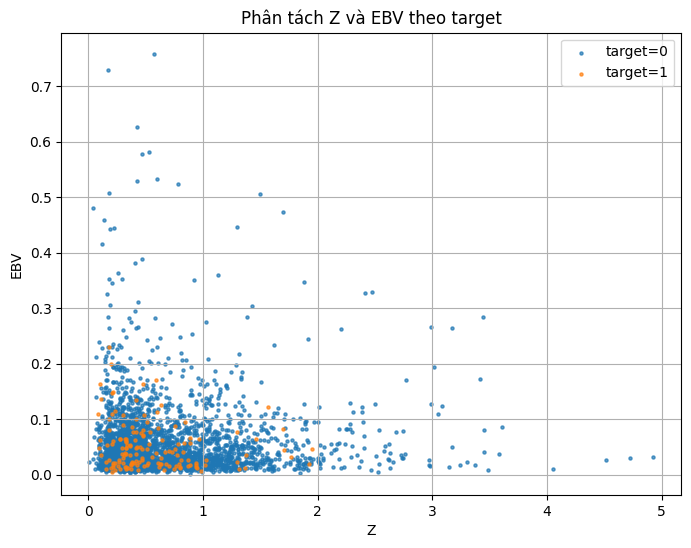

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8, 6))

for label in train_df['target'].unique():
    subset = train_df[train_df['target'] == label]
    plt.scatter(
        subset['Z'],
        subset['EBV'],
        label=f'target={label}',
        alpha=0.7,
        s=5
    )

plt.xlabel('Z')
plt.ylabel('EBV')
plt.title('Phân tách Z và EBV theo target')
plt.legend()
plt.grid(True)
plt.show()

- TDE có redshift (dịch chuyển đỏ) nhỏ => TDE thường được quan sát gần

In [10]:
filter_colours = {'u': '#6A5ACD', 'g': '#2ca02c', 'r': '#d62728', 'i': '#ff7f0e', 'z': '#8c564b', 'y': '#1b1b1b'}

def plot_lightcurves(dfs, flux_col="Flux", names=None, filter_colours=filter_colours):
    for i, df_lc in enumerate(dfs):
        df_lc = df_lc.sort_values("Time (MJD)")
        times = df_lc["Time (MJD)"]
        flux = df_lc[flux_col]

        if names:
            color = filter_colours[names[i]] if filter_colours else None
            plt.plot(times, flux, label=names[i], color=color)
        else:
            plt.plot(times, flux)

    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.legend()

In [11]:
def plot_lc_for_id(object_id, flux_col="Flux"):
    split_folder = train_df[train_df["object_id"] == object_id].iloc[0]["split"]
    lightcurve_path = f"/kaggle/input/mallorn-dataset/{split_folder}/train_full_lightcurves.csv"

    lightcurve_df = pd.read_csv(lightcurve_path)


    lightcurve_df = lightcurve_df[lightcurve_df["object_id"] == object_id]
    
    u_lc = lightcurve_df[lightcurve_df["Filter"] == "u"]
    g_lc = lightcurve_df[lightcurve_df["Filter"] == "g"]
    r_lc = lightcurve_df[lightcurve_df["Filter"] == "r"]
    i_lc = lightcurve_df[lightcurve_df["Filter"] == "i"]
    z_lc = lightcurve_df[lightcurve_df["Filter"] == "z"]
    y_lc = lightcurve_df[lightcurve_df["Filter"] == "y"]
    
    plot_lightcurves([u_lc, g_lc, r_lc, i_lc, z_lc, y_lc], flux_col=flux_col, names=["u", "g", "r", "i", "z", "y"])

In [12]:
train_df.sample(2)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


object_id       Z  Z_err    EBV SpecType  \
1007  haradrim_dol_lasguil  0.4068    NaN  0.142    SN Ia   
1703      cabed_ang_sirion  0.3433    NaN  0.016      AGN   

                         English Translation     split  target  
1007  People of the South + head, hill + tea  split_07       0  
1703                    leap + iron + river   split_12       0

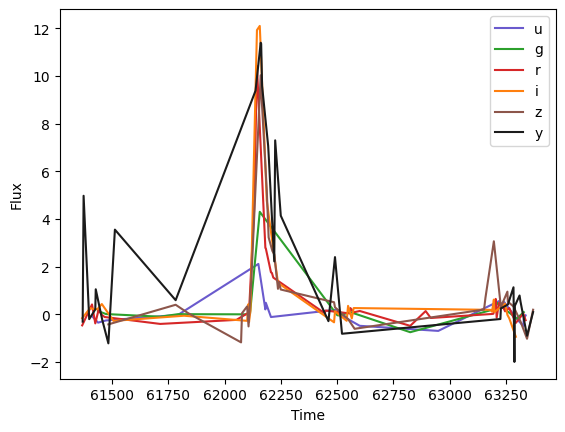

In [13]:
plot_lc_for_id("loss_anann_yll")

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_multi_lightcurves(
    object_ids: list[str],
    flux_col="Flux",
    flux_err_col="Flux_err",
    plot_flux_err=False,
    figsize=(8, 3),
    ncols=1,
    filters: list[str] = ["u", "g", "r", "i", "z", "y"],
    base_path: str = "/kaggle/input/mallorn-dataset",
    train_test: str = "train",
    split_col="split",
):
    filter_colours = {
        'u': '#6A5ACD',
        'g': '#2ca02c',
        'r': '#d62728',
        'i': '#ff7f0e',
        'z': '#8c564b',
        'y': '#1b1b1b'
    }
    
    n = len(object_ids)
    nrows = math.ceil(n / ncols)
    
    fig, axs = plt.subplots(
        nrows, ncols,
        figsize=(figsize[0]*ncols, figsize[1]*nrows),
        # sharex=True
    )
    
    if nrows * ncols == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    for ax, object_id in zip(axs, object_ids):
        row = train_df[train_df["object_id"] == object_id]
        if row.empty:
            ax.set_title(f"{object_id} (NOT FOUND)")
            continue

        split = row.iloc[0][split_col]
        lc_path = f"{base_path}/{split}/{train_test}_full_lightcurves.csv"

        lc_df = pd.read_csv(lc_path)
        lc_df = lc_df[lc_df["object_id"] == object_id]

        if lc_df.empty:
            ax.set_title(f"{object_id} (NO DATA)")
            continue

        for f in filters:
            df_f = lc_df[lc_df["Filter"] == f].sort_values("Time (MJD)")
            if df_f.empty:
                continue

            color = filter_colours[f]

            # Vẽ đường flux
            ax.plot(
                df_f["Time (MJD)"],
                df_f[flux_col],
                label=f,
                color=color,
                lw=1.5
            )

            # Vẽ vùng sai số nếu được yêu cầu
            if plot_flux_err and flux_err_col in df_f.columns:
                flux = df_f[flux_col].values
                err = df_f[flux_err_col].values
                time = df_f["Time (MJD)"].values

                ax.fill_between(
                    time,
                    flux - err,
                    flux + err,
                    color=color,
                    alpha=0.25,
                    linewidth=0
                )

        ax.set_title(object_id, fontsize=10)
        ax.set_ylabel(flux_col)
        ax.legend(ncol=len(filters), fontsize=8)

    for ax in axs[len(object_ids):]:
        ax.axis('off')

    plt.xlabel("Time (MJD)")
    plt.tight_layout()
    plt.show()

In [15]:
samples = train_df.groupby("target").sample(20)

positive_sample_ids = samples[samples["target"] == 1]["object_id"].to_list()
negative_sample_ids = samples[samples["target"] == 0]["object_id"].to_list()

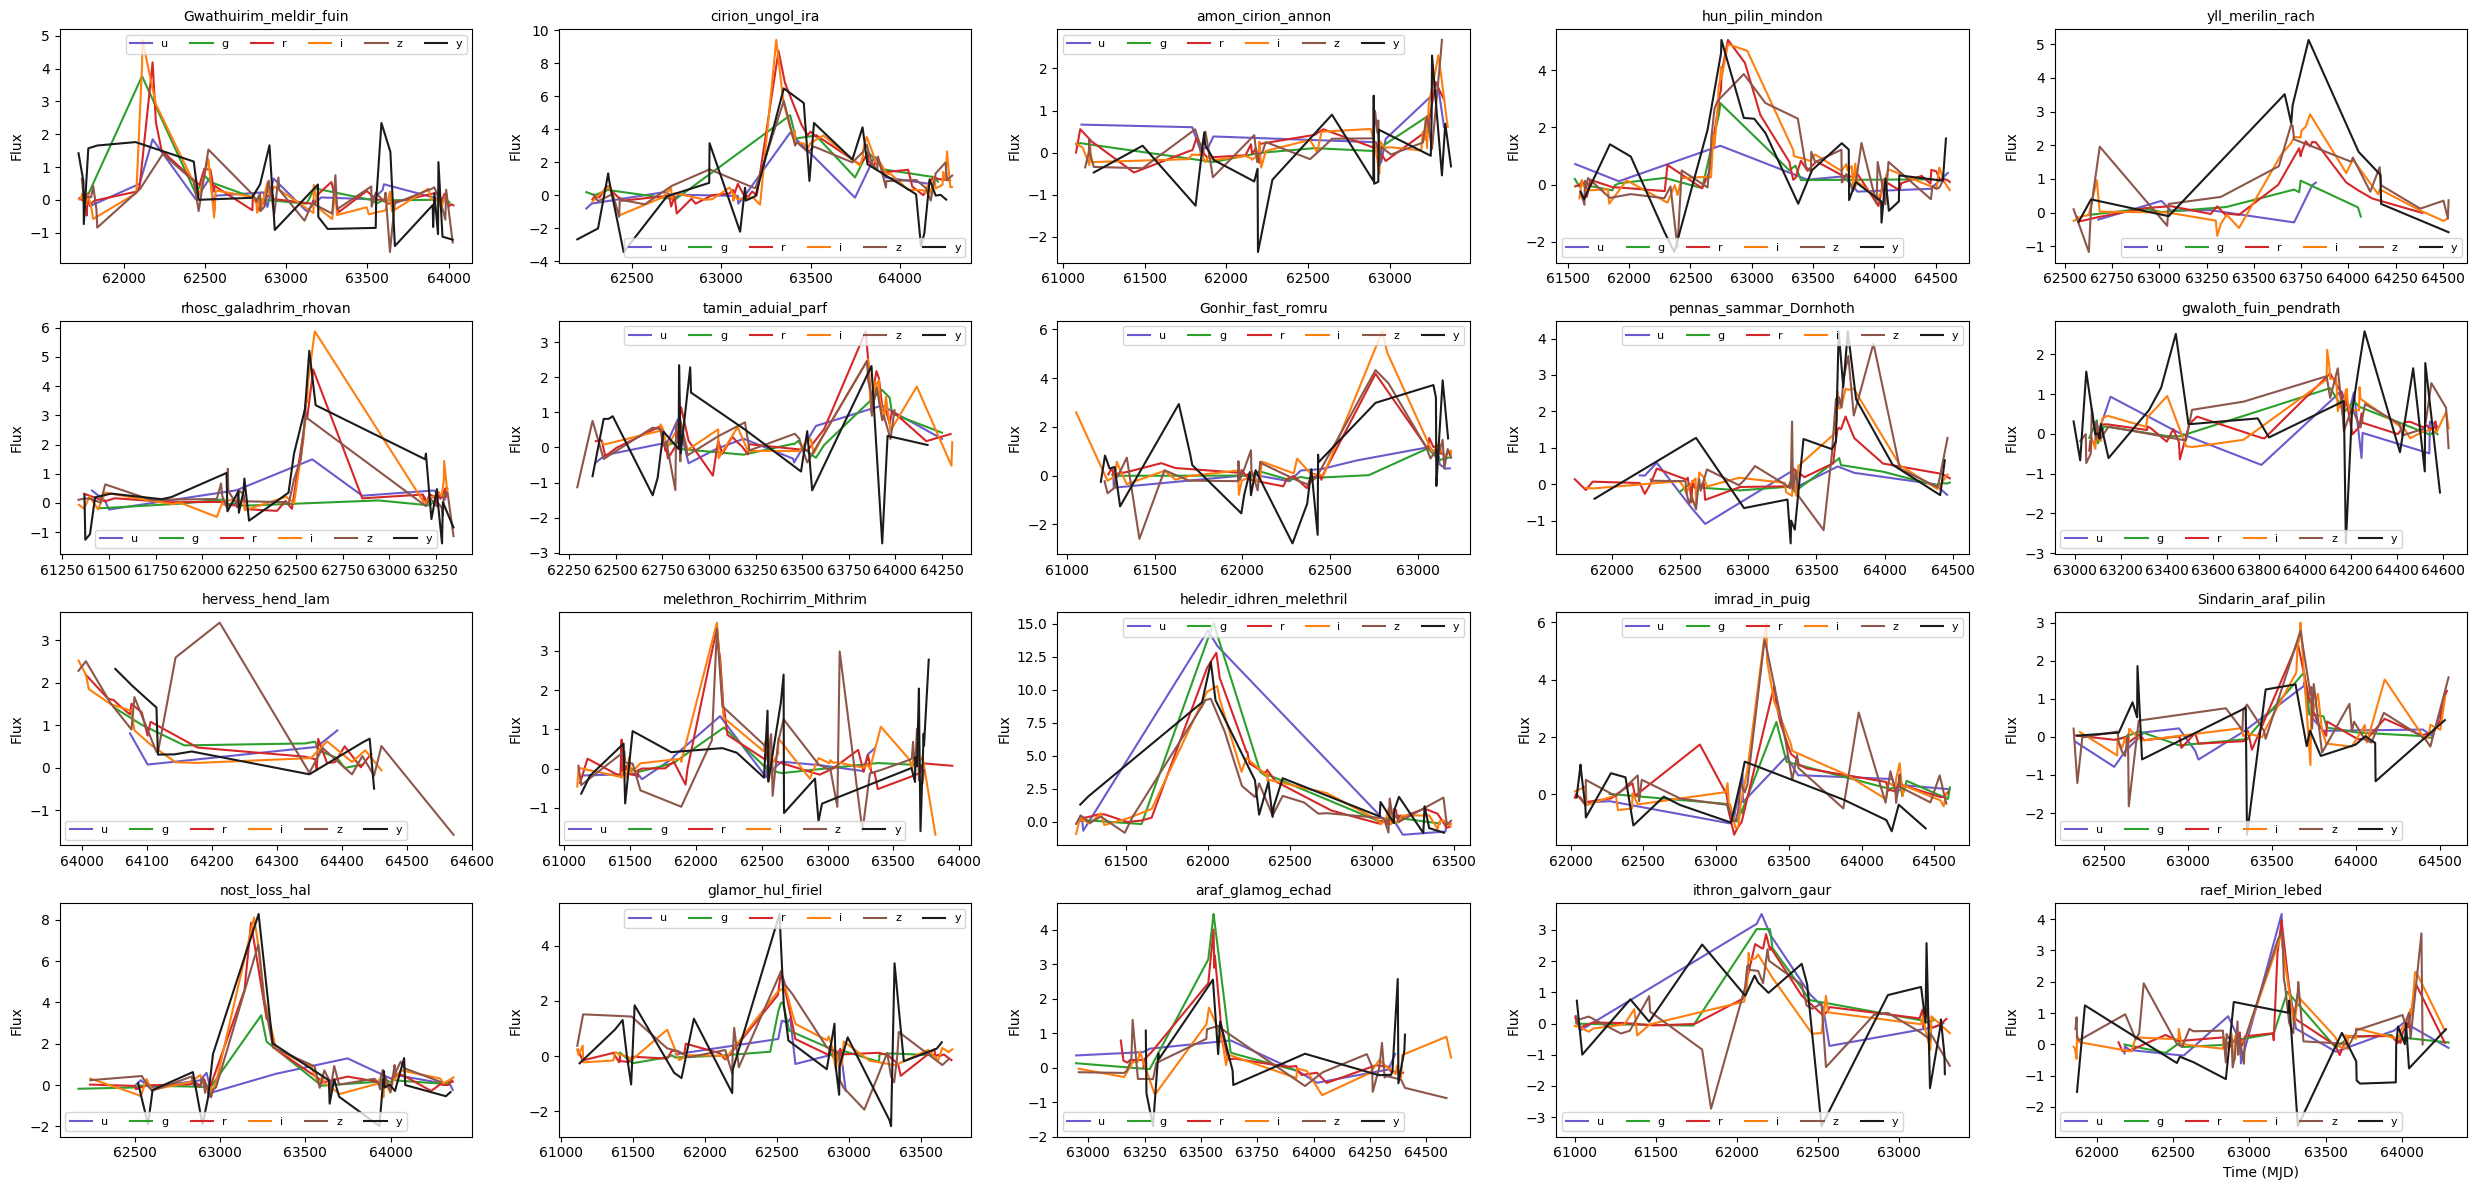

In [16]:
plot_multi_lightcurves(
    positive_sample_ids,
    figsize=(5, 3),
    ncols=5
)

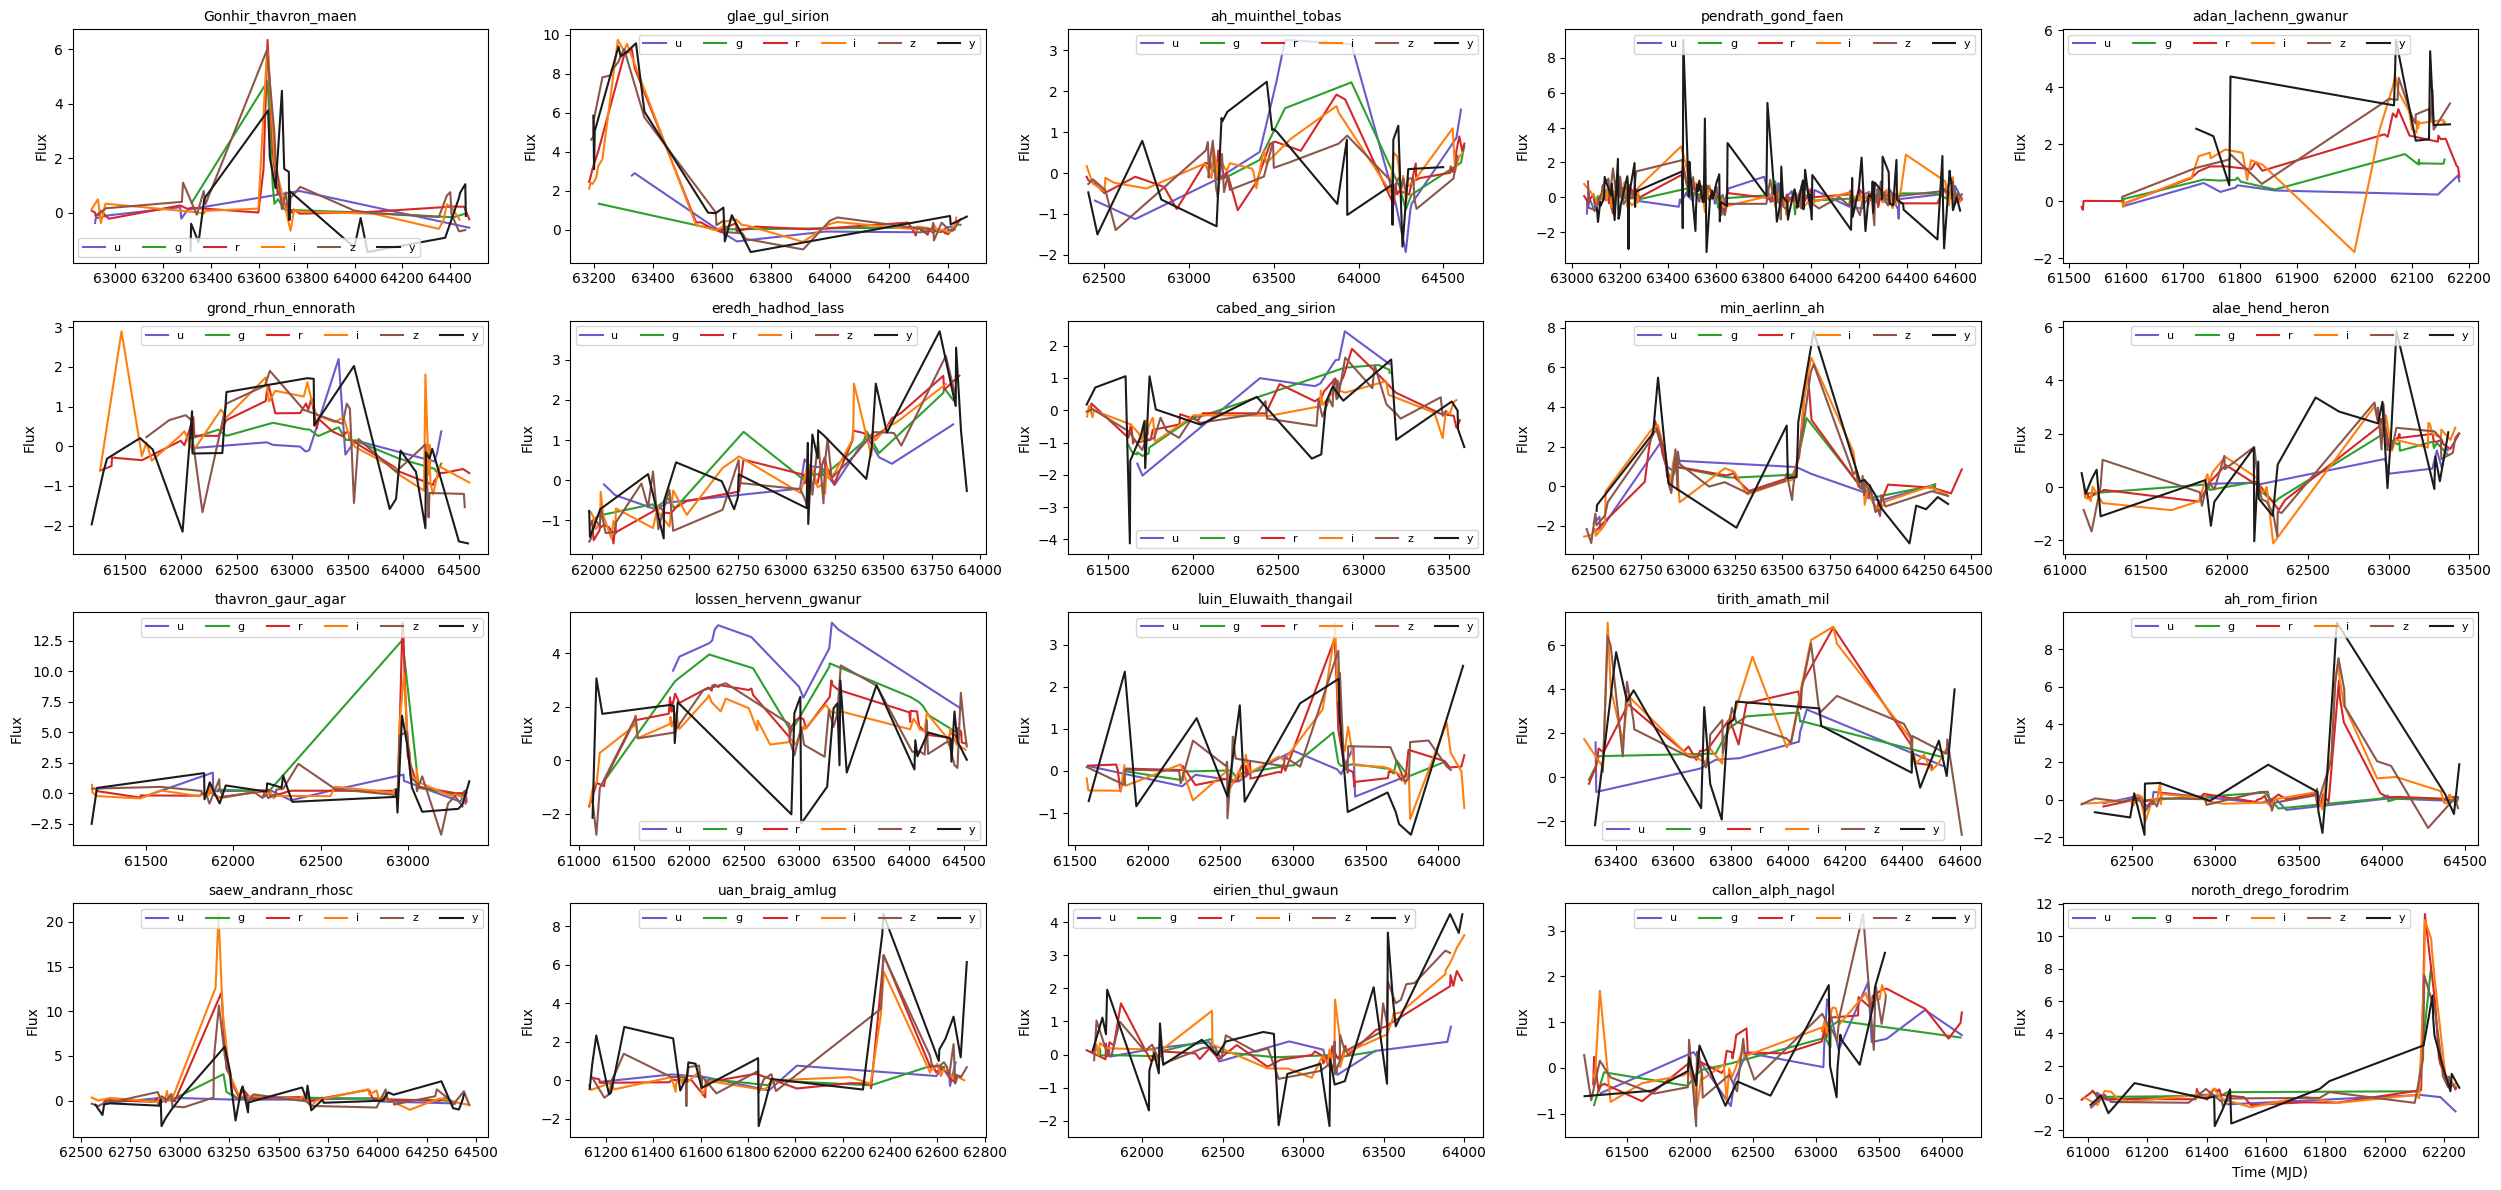

In [17]:
plot_multi_lightcurves(
    negative_sample_ids,
    figsize=(5, 3),
    ncols=5
)

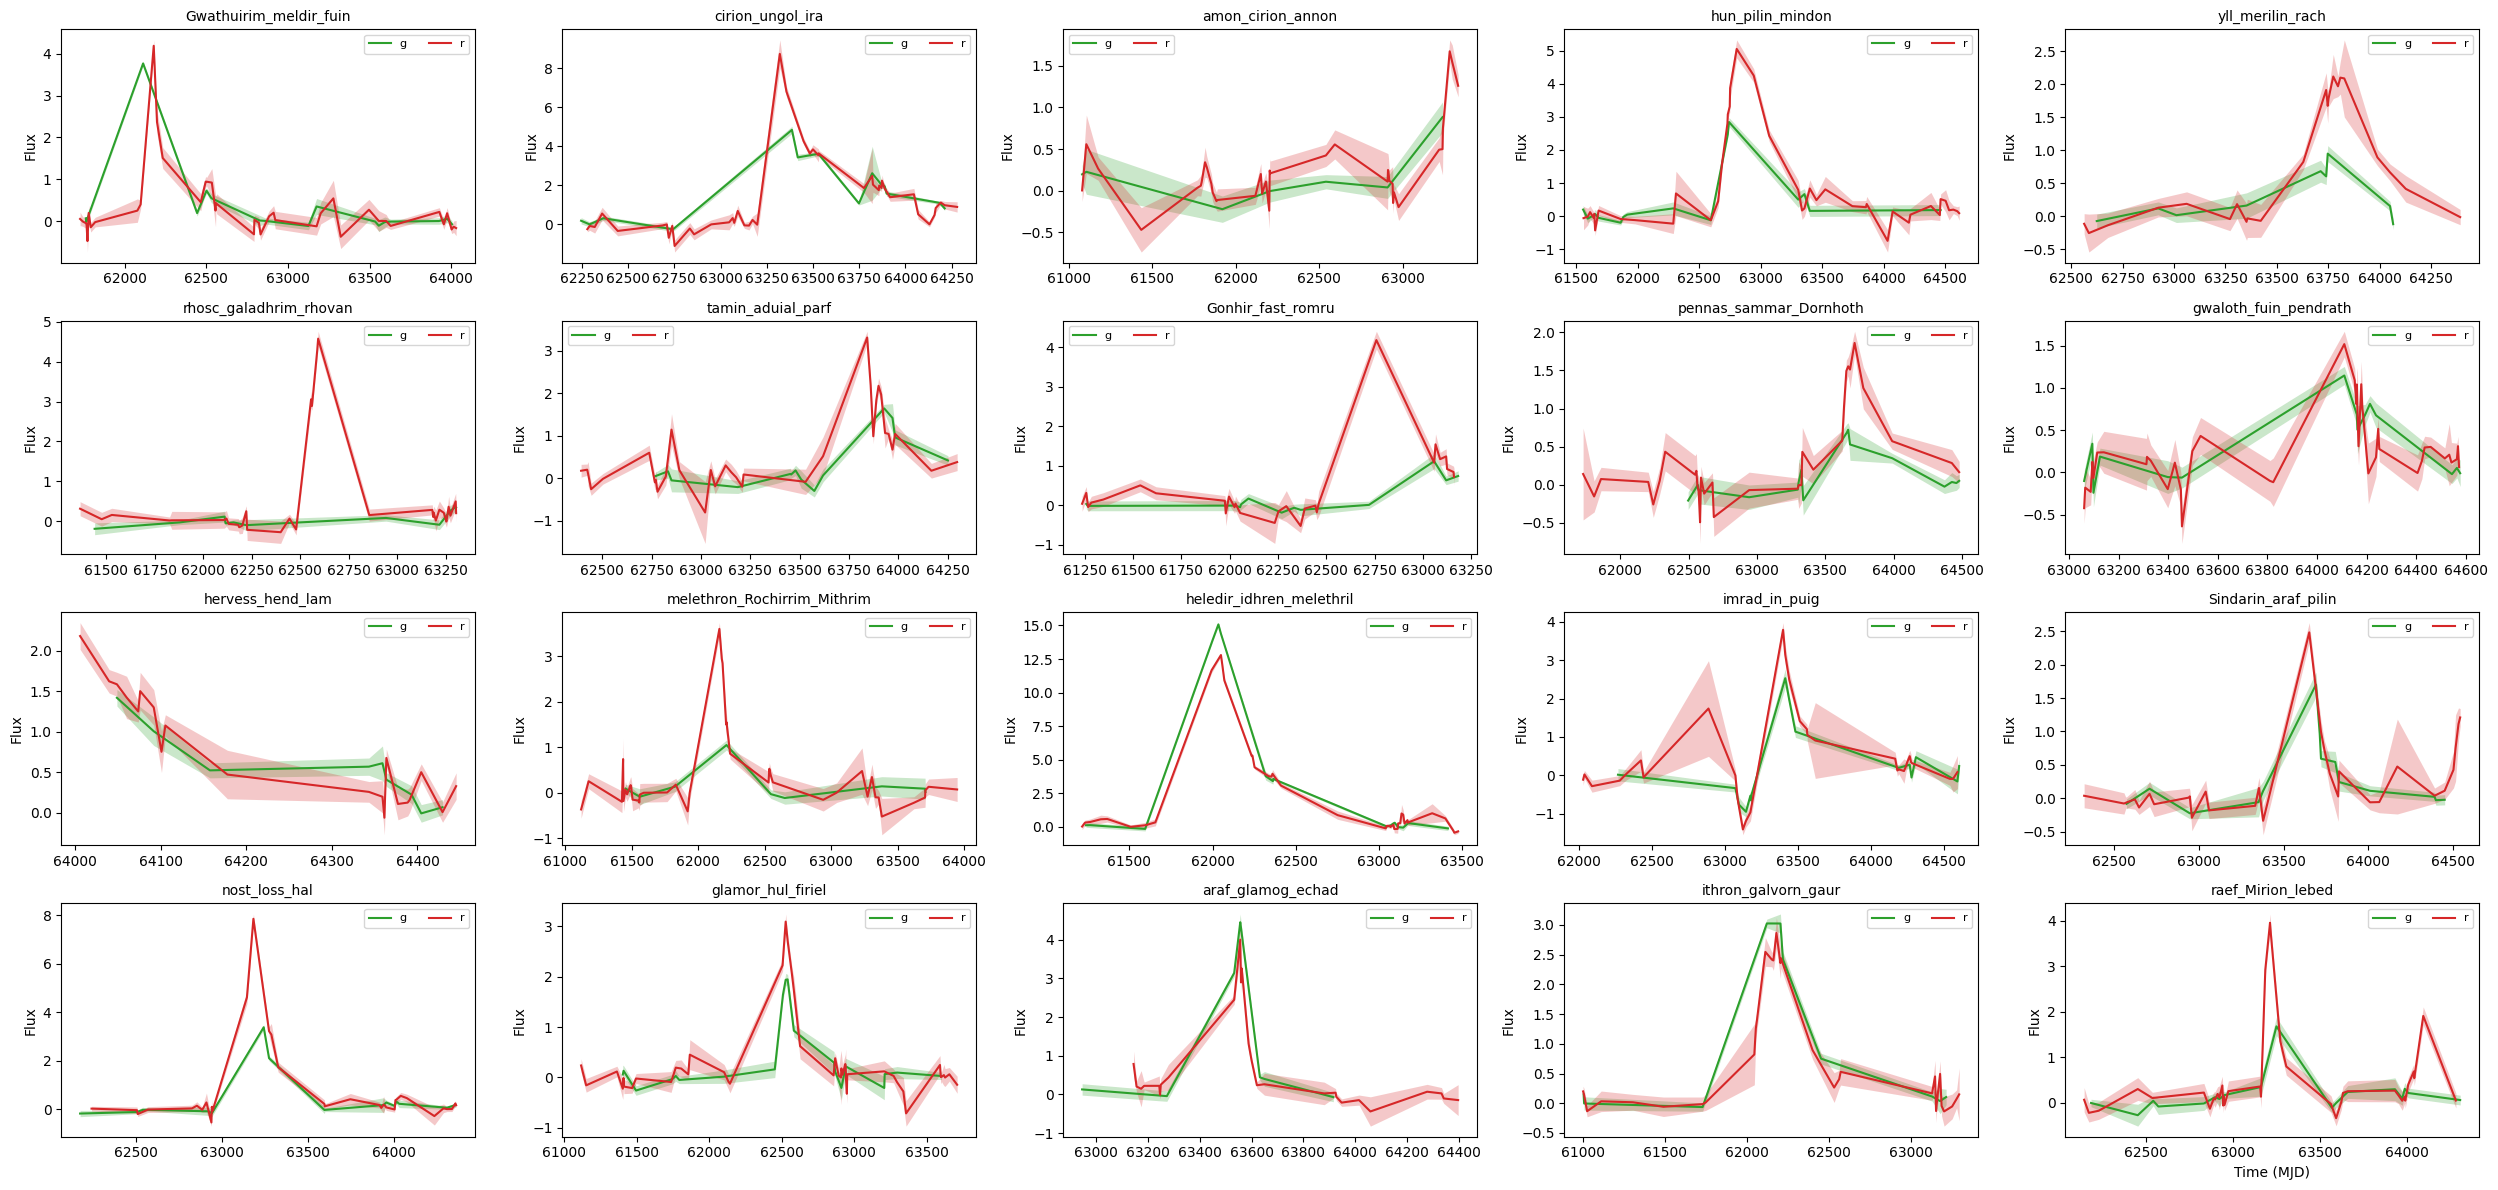

In [18]:
plot_multi_lightcurves(
    positive_sample_ids,
    figsize=(5, 3),
    ncols=5,
    filters=["g", "r"],
    plot_flux_err=True
)

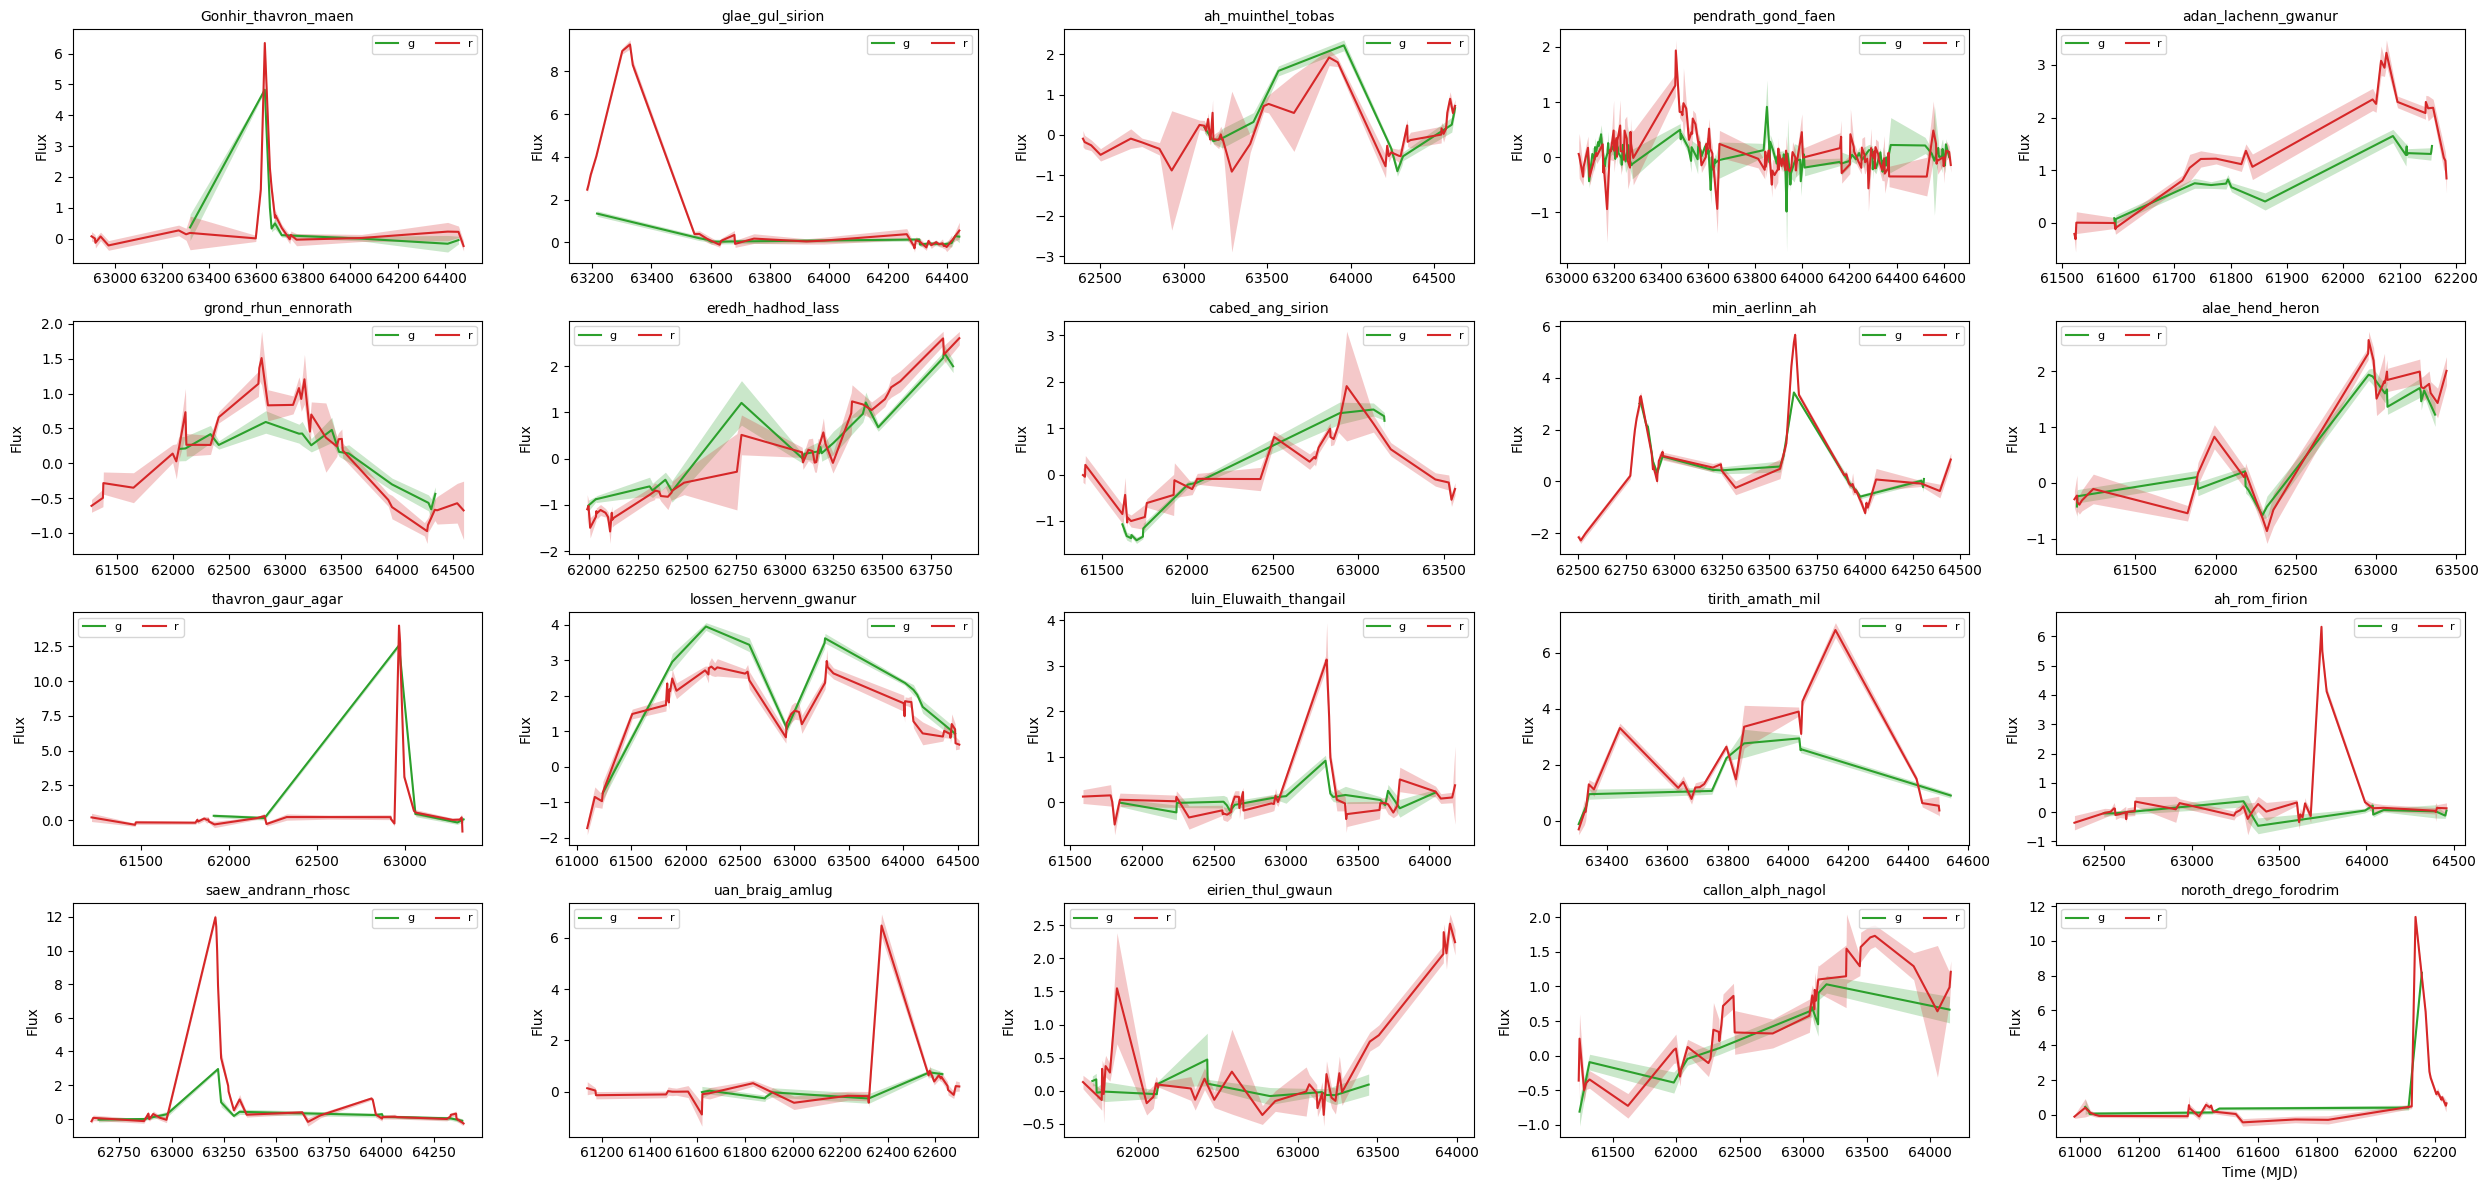

In [19]:
plot_multi_lightcurves(
    negative_sample_ids,
    figsize=(5, 3),
    ncols=5,
    filters=["g", "r"],
    plot_flux_err=True
)

Using_the_Data notebook:

$F_{true}=F_{obs} \times 10^{\frac{A_\lambda}{2.5}}$

$\sigma_{true}=\sigma_{obs} \times 10^{\frac{A_\lambda}{2.5}}$

${A_\lambda}$ phụ thuộc vào: Filter, E(B−V), Extinction law (Fitzpatrick99, ${R_V=3.2}$)

In [20]:
!pip install extinction==0.4.7

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.1/600.1 kB 9.9 MB/s eta 0:00:00


In [21]:
from extinction import fitzpatrick99
import numpy as np
import os
from tqdm import tqdm

In [22]:
# Calculate flux_true 
flux_true_base_url = "lightcurves_flux_true"

eff_wavelengths = { "u": 3641, "g": 4704, "r": 6155, "i": 7504, "z": 8695, "y": 10056 }
R_V = 3.1

In [23]:
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    # print(row)
    split = row["split"]
    object_id = row["object_id"]
    ebv = row["EBV"]

    # print(split, object_id, ebv)
    
    lightcurves_path = f"/kaggle/input/mallorn-dataset/{split}/train_full_lightcurves.csv"
    # print(lightcurves_path)
    lightcurves_df = pd.read_csv(lightcurves_path)
    lightcurves_df = lightcurves_df[lightcurves_df["object_id"] == object_id]

    A_lambda = lightcurves_df["Filter"].map(
        lambda f: fitzpatrick99(
            np.array([eff_wavelengths[f]]),
            ebv * R_V
        )[0]
    )

    scale = 10 ** (A_lambda / 2.5)

    lightcurves_df["Flux_true"] = lightcurves_df["Flux"] * scale
    lightcurves_df["Flux_err_true"] = lightcurves_df["Flux_err"] * scale
    
    # print(lightcurves_df.shape)
    # print(lightcurves_df.sample(5))

    os.makedirs(f"{flux_true_base_url}/{object_id}", exist_ok=True)
    save_path = f"{flux_true_base_url}/{object_id}/train_full_lightcurves.csv"
    lightcurves_df.to_csv(save_path)

100%|██████████| 3043/3043 [01:19<00:00, 38.35it/s]


In [24]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # print(row)
    split = row["split"]
    object_id = row["object_id"]
    ebv = row["EBV"]

    # print(split, object_id, ebv)
    
    lightcurves_path = f"/kaggle/input/mallorn-dataset/{split}/test_full_lightcurves.csv"
    # print(lightcurves_path)
    lightcurves_df = pd.read_csv(lightcurves_path)
    lightcurves_df = lightcurves_df[lightcurves_df["object_id"] == object_id]

    A_lambda = lightcurves_df["Filter"].map(
        lambda f: fitzpatrick99(
            np.array([eff_wavelengths[f]]),
            ebv * R_V
        )[0]
    )

    scale = 10 ** (A_lambda / 2.5)

    lightcurves_df["Flux_true"] = lightcurves_df["Flux"] * scale
    lightcurves_df["Flux_err_true"] = lightcurves_df["Flux_err"] * scale
    
    # print(lightcurves_df.shape)
    # print(lightcurves_df.sample(5))

    os.makedirs(f"{flux_true_base_url}/{object_id}", exist_ok=True)
    save_path = f"{flux_true_base_url}/{object_id}/test_full_lightcurves.csv"
    lightcurves_df.to_csv(save_path)

100%|██████████| 7135/7135 [06:29<00:00, 18.33it/s]


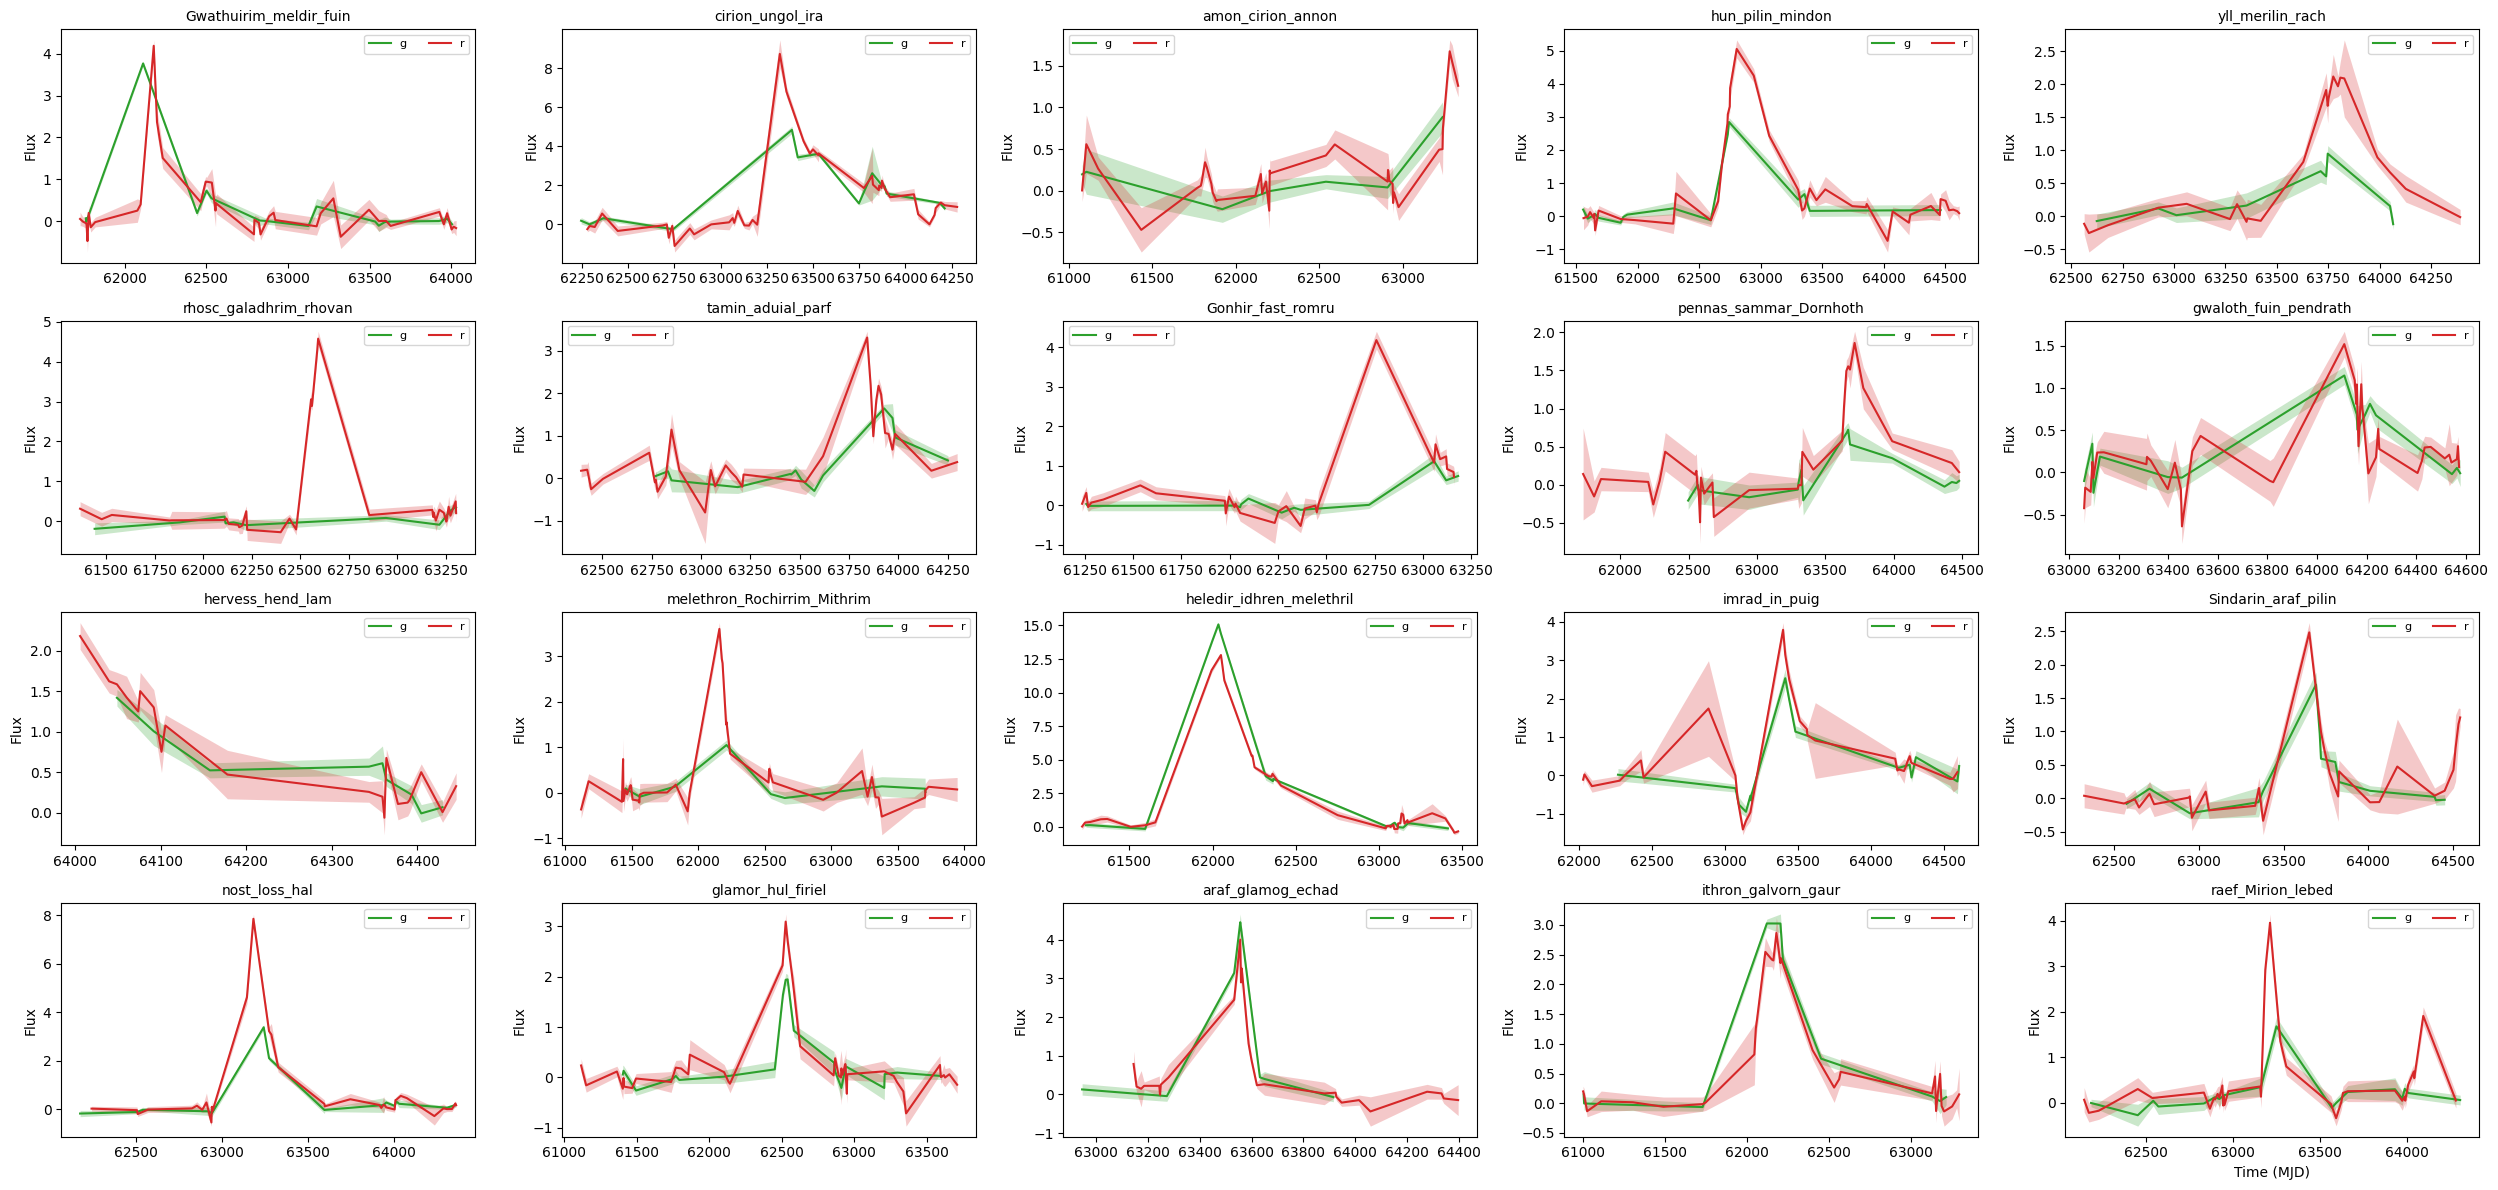

In [25]:
plot_multi_lightcurves(
    positive_sample_ids,
    figsize=(5, 3),
    ncols=5,
    filters=["g", "r"],
    plot_flux_err=True
)

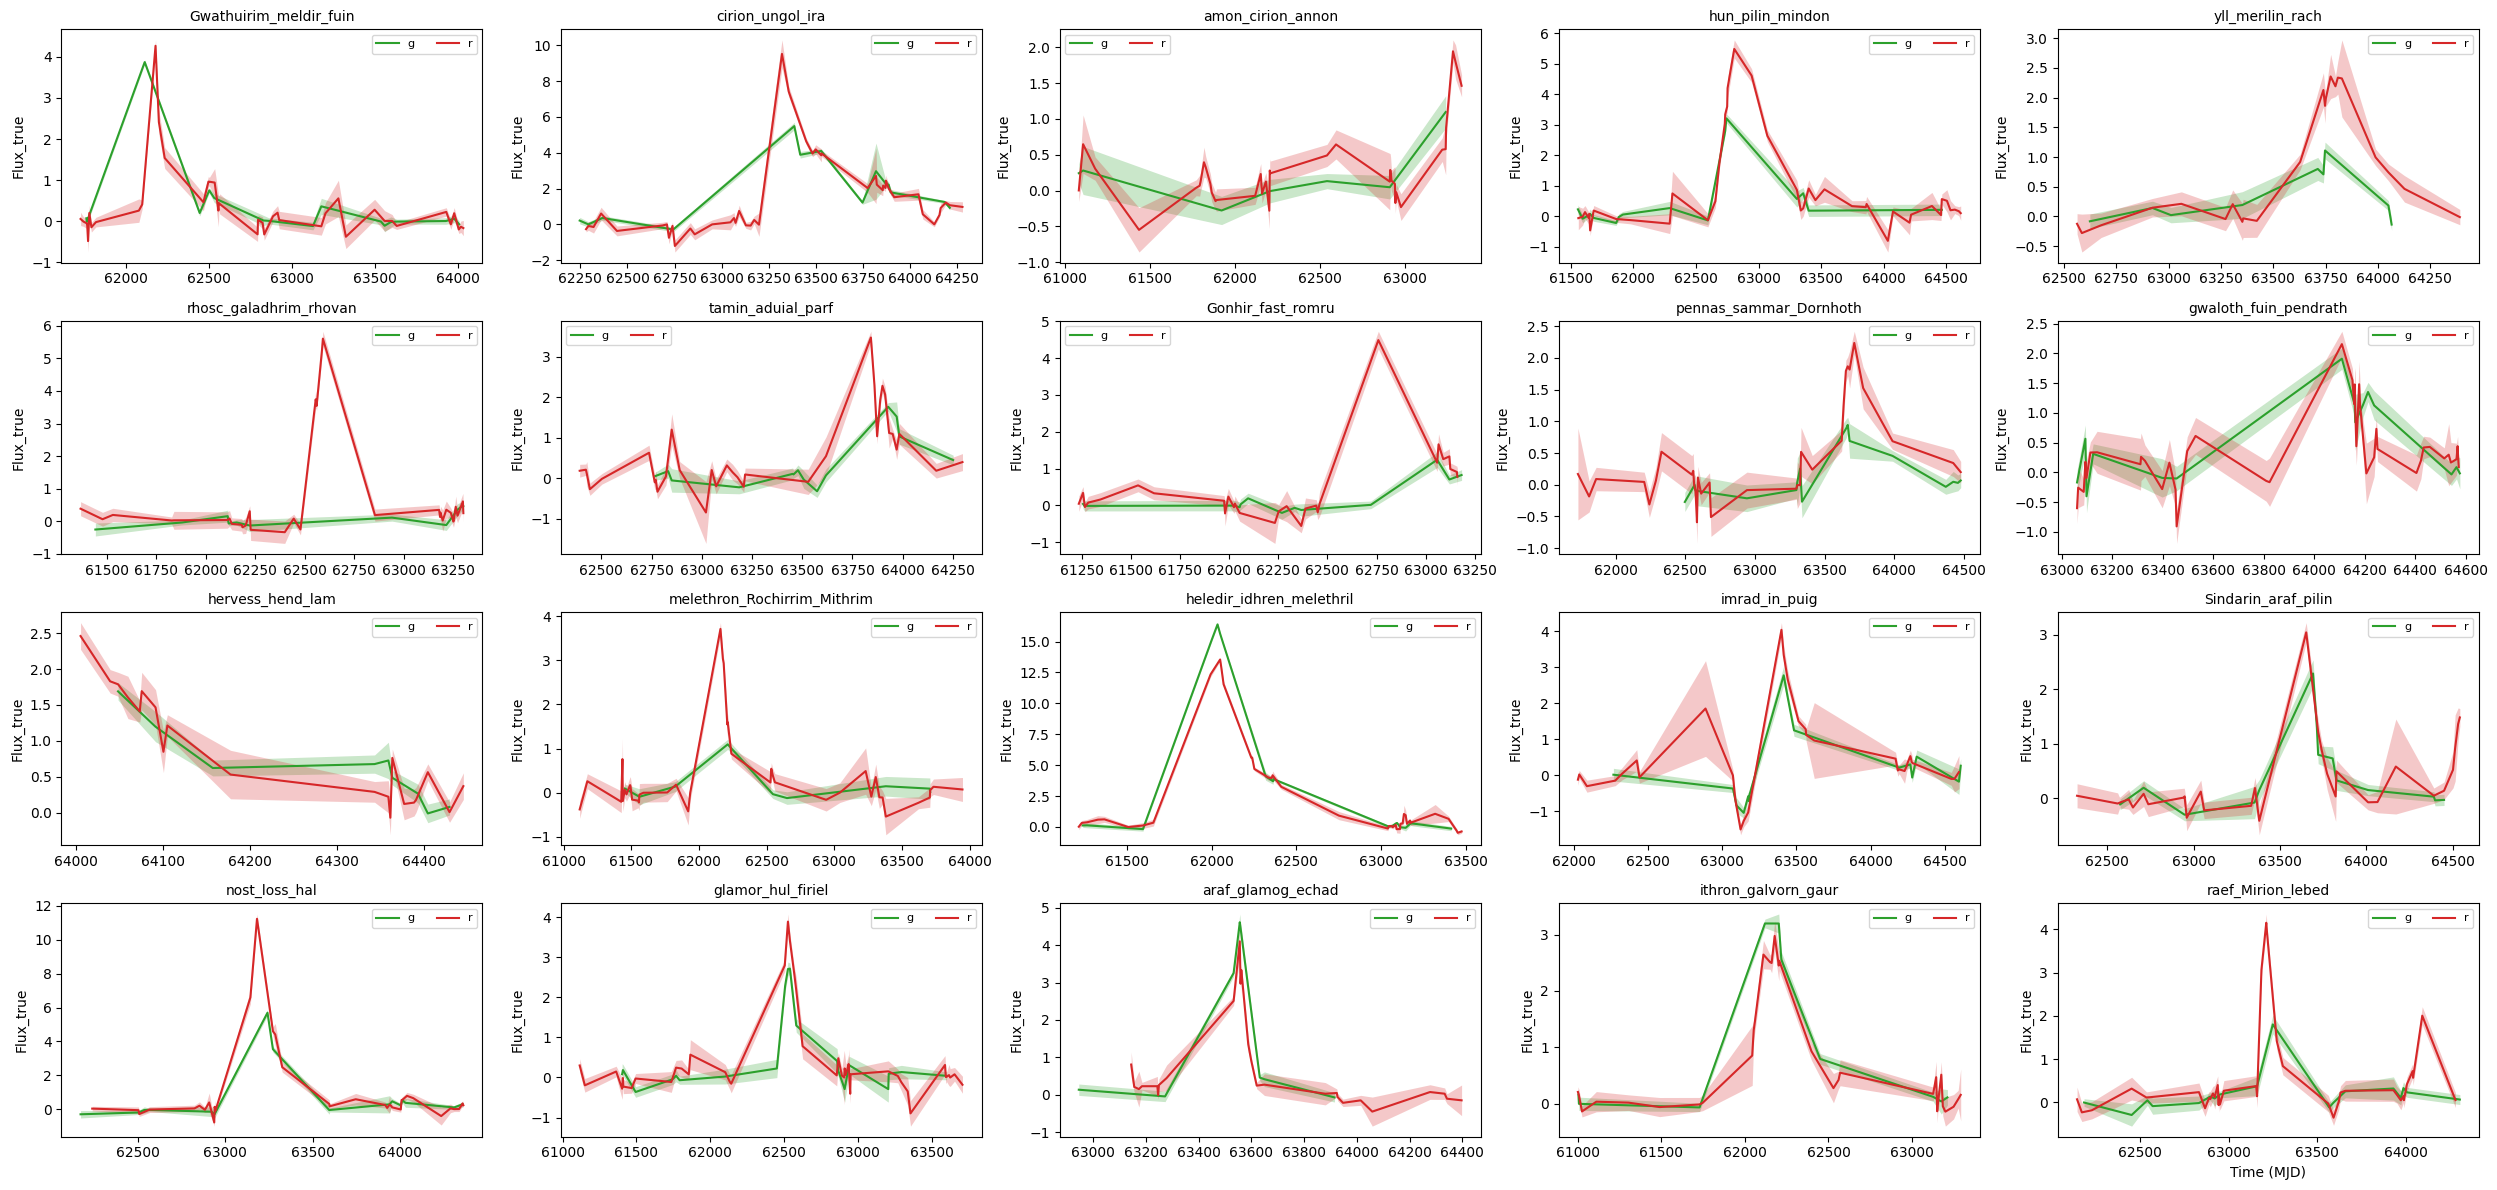

In [26]:
plot_multi_lightcurves(
    positive_sample_ids,
    figsize=(5, 3),
    ncols=5,
    filters=["g", "r"],
    base_path=flux_true_base_url,
    train_test="train",
    split_col="object_id",
    flux_col="Flux_true",
    plot_flux_err=True,
    flux_err_col="Flux_err_true"
)

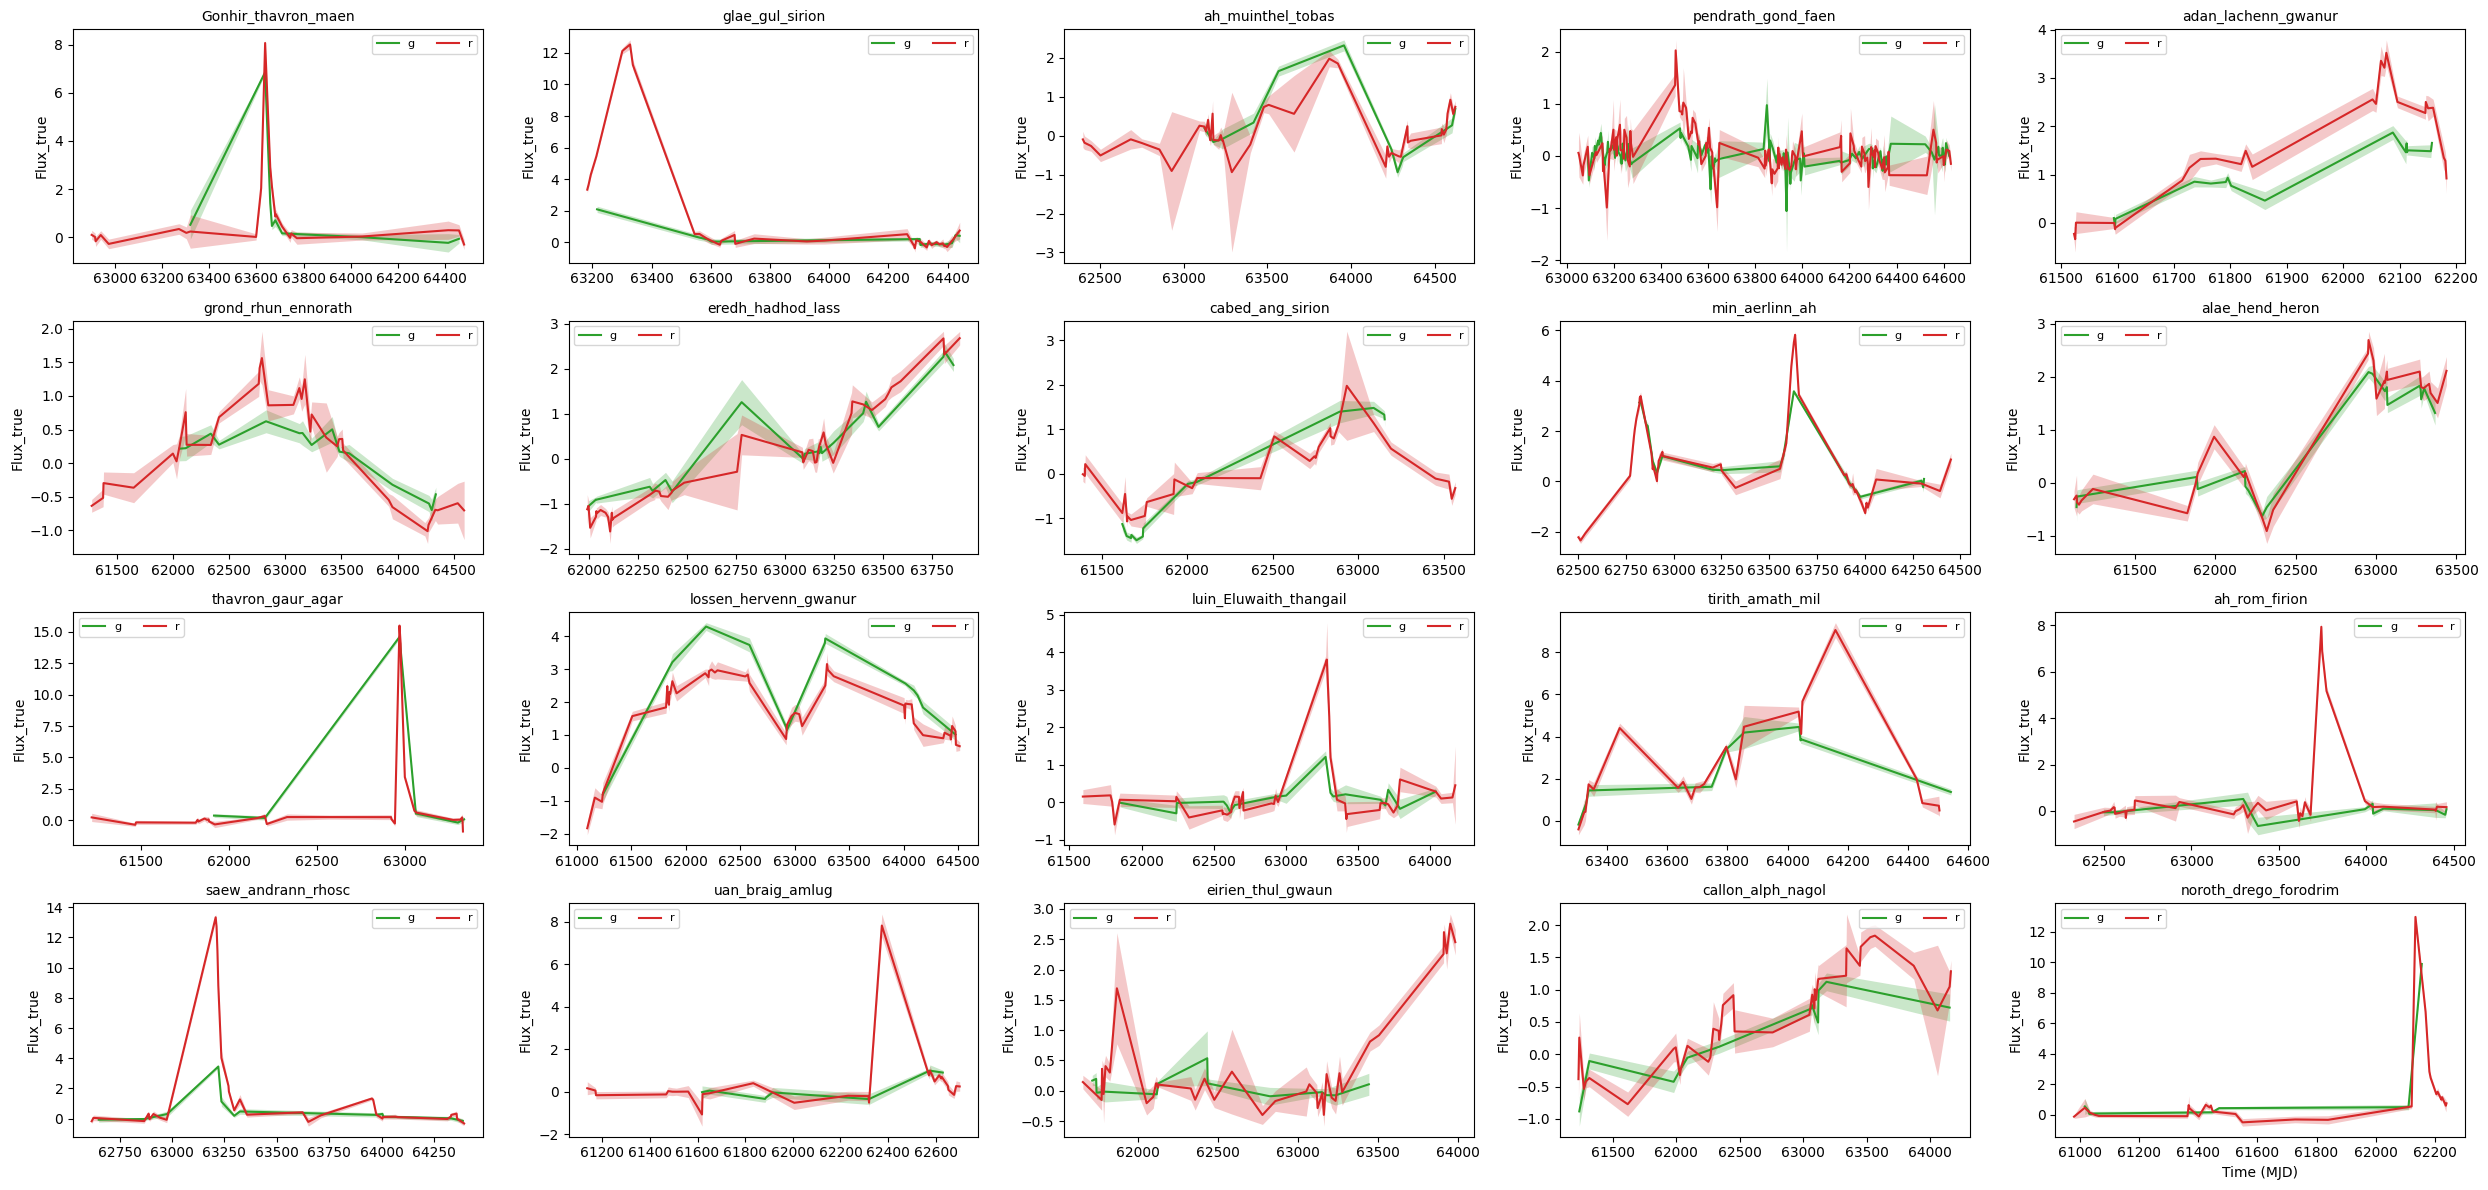

In [27]:
plot_multi_lightcurves(
    negative_sample_ids,
    figsize=(5, 3),
    ncols=5,
    filters=["g", "r"],
    base_path=flux_true_base_url,
    train_test="train",
    split_col="object_id",
    flux_col="Flux_true",
    plot_flux_err=True,
    flux_err_col="Flux_err_true"
)

# Model

In [28]:
!pip install -q optuna catboost

In [29]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve

def find_best_threshold(y_true, y_prob):
    """
    Hàm phụ trợ: Tìm ngưỡng (threshold) cho F1 cao nhất.
    Thay vì đoán mò 0.5, hàm này quét qua các ngưỡng để tìm điểm 'ngon' nhất.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10) # +epsilon để tránh chia cho 0
    best_idx = np.argmax(f1_scores)
    
    # Trả về ngưỡng tốt nhất và F1 tương ứng
    # (thresholds ngắn hơn f1_scores 1 đơn vị nên cần xử lý chút)
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    best_f1 = f1_scores[best_idx]
    return best_thresh, best_f1

def objective_catboost(trial, X, y):
    """
    Hàm mục tiêu cho Optuna tối ưu hóa.
    """
    # 1. Định nghĩa không gian tham số (Search Space)
    # Lưu ý: Với dữ liệu nhỏ (3000 dòng), đừng để depth quá sâu (dễ overfit)
    params = {
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'depth': trial.suggest_int('depth', 3, 7), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
        
        # CỐ ĐỊNH: Các tham số quan trọng cho Imbalance
        'loss_function': 'Logloss',
        'eval_metric': 'F1',
        'auto_class_weights': 'Balanced', # Tự động cân bằng trọng số (Key!)
        'verbose': 0,
        'allow_writing_files': False,
        'random_seed': 42
    }

    # 2. Chiến thuật Validation: Repeated Stratified K-Fold
    # Lặp lại 3 lần, mỗi lần chia 5 fold -> Tổng 15 lần train/test để chắc ăn
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    
    f1_scores = []
    
    # Chuyển X, y về numpy array để tránh lỗi index
    X_val_np = X.values if isinstance(X, pd.DataFrame) else X
    y_val_np = y.values if isinstance(y, pd.Series) else y

    for train_index, val_index in rskf.split(X_val_np, y_val_np):
        X_train_fold, X_val_fold = X_val_np[train_index], X_val_np[val_index]
        y_train_fold, y_val_fold = y_val_np[train_index], y_val_np[val_index]

        # Train model
        model = CatBoostClassifier(**params)
        model.fit(X_train_fold, y_train_fold)
        
        # Dự đoán xác suất (predict_proba) thay vì nhãn cứng
        preds_proba = model.predict_proba(X_val_fold)[:, 1]
        
        # TÌM NGƯỠNG TỐI ƯU TRÊN TẬP VAL
        _, best_f1 = find_best_threshold(y_val_fold, preds_proba)
        f1_scores.append(best_f1)

    # Mục tiêu của Optuna là tối đa hóa F1 trung bình
    return np.mean(f1_scores)

def run_optimization(X, y, n_trials=20):
    """
    Hàm wrapper để chạy toàn bộ quy trình.
    """
    print(f"🚀 Bắt đầu tối ưu hóa với shape: {X.shape}...")
    
    study = optuna.create_study(direction='maximize')
    
    # Sử dụng lambda để truyền X, y vào hàm objective
    func = lambda trial: objective_catboost(trial, X, y)
    
    study.optimize(func, n_trials=n_trials)
    
    print("\n✅ Kết thúc tối ưu!")
    print(f"F1-Score tốt nhất (trung bình CV): {study.best_value:.4f}")
    print("Bộ tham số đỉnh nhất:")
    for key, value in study.best_params.items():
        print(f"    {key}: {value}")
        
    return study.best_params

In [30]:
def find_best_model(X, y):
    best_params = run_optimization(X, y, n_trials=20)

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.1, stratify=y, random_state=42
    )

    final_params = best_params.copy()
    final_params.update({
        'loss_function': 'Logloss',
        'auto_class_weights': 'Balanced',
        'verbose': 0
    })

    model = CatBoostClassifier(**final_params)
    model.fit(X_train, y_train)
    
    y_proba = model.predict_proba(X_val)[:, 1]
    best_threshold, best_f1 = find_best_threshold(y_val, y_proba)
    
    print(f"Best threshold = {best_threshold:.4f}")
    print(f"F1 at best threshold = {best_f1:.4f}")
    
    print("\nFeature Importance:")
    feat_importances = pd.Series(model.get_feature_importance(), index=X_train.columns)
    print(feat_importances.sort_values(ascending=False))

    return model, best_params, best_threshold

In [31]:
def predict_with_threshold(model, X, threshold):
    y_proba = model.predict_proba(X)[:, 1]
    return (y_proba >= threshold).astype(int)

## Manual Feature Engineering 5
- Chọn 9 features:
    * Max g
    * Max r
    * g - r: TDE thường xanh hơn các hiện tượng khác
    * Rise Time (Thời gian bùng nổ)
    * n_detections (Số lượng điểm dữ liệu có tín hiệu dương)
    * n_detections_ratio
    * u - g
    * r - i
    * luminosity_g: proxy luminosity

## emitted energy

In [32]:
import numpy as np
import pandas as pd

# --- deps ---
# Nếu thiếu astropy thì (tránh cài lại mỗi lần chạy):
try:
    from astropy.cosmology import WMAP9 as cosmo
    import astropy.units as u
except Exception:
    !pip install -q astropy
    from astropy.cosmology import WMAP9 as cosmo
    import astropy.units as u

# --- constants ---
MICROJY_TO_CGS = 1e-29   # 1 μJy = 1e-29 erg/s/cm^2/Hz
DAY_TO_SEC = 86400.0
C = 299792458.0          # m/s

# LSST band edges (nm) -> dùng để ước lượng độ rộng dải tần Δν của từng band
BAND_LAMBDA_NM = {
    "u": (338.0, 395.0),
    "g": (405.0, 552.0),
    "r": (553.0, 690.0),
    "i": (690.0, 817.0),
    "z": (818.0, 920.0),
    "y": (920.0, 1010.0),
}

def luminosity_distance_cm(z: float) -> float:
    """Tính luminosity distance D_L (cm) từ redshift z. z<=0/NaN -> NaN."""
    if z is None or (not np.isfinite(z)) or z <= 0:
        return np.nan
    return cosmo.luminosity_distance(z).to(u.cm).value

def trapz_irregular(t_days: np.ndarray, y: np.ndarray) -> float:
    """∫ y(t) dt với t là MJD (days), y là (/s). Trả về y*sec (tức đã đổi sang giây)."""
    if t_days is None or y is None or len(t_days) < 2:
        return 0.0
    order = np.argsort(t_days)
    t = t_days[order]
    f = y[order]
    dt_sec = np.diff(t) * DAY_TO_SEC
    return float(np.sum(0.5 * (f[:-1] + f[1:]) * dt_sec))

def delta_nu_from_lambda_nm(lmin_nm, lmax_nm):
    """Từ [λ_min, λ_max] (nm) -> Δν = c(1/λ_min - 1/λ_max) (Hz)."""
    lmin = lmin_nm * 1e-9
    lmax = lmax_nm * 1e-9
    return C * (1.0 / lmin - 1.0 / lmax)

DELTA_NU = {b: delta_nu_from_lambda_nm(*rng) for b, rng in BAND_LAMBDA_NM.items()}

def emitted_energy_features_from_lc(
    lc: pd.DataFrame,
    z: float,
    flux_col: str = "Flux_true",
    err_col: str = "Flux_err_true",
    time_col: str = "Time (MJD)",
    filter_col: str = "Filter",
    positive_only: bool = True,
    snr_min: float | None = 0.0,
    bands_out: tuple[str, ...] = ("u", "g", "r"),                 # <-- mặc định chỉ TRẢ 3 band
    bands_all: tuple[str, ...] = ("u", "g", "r", "i", "z", "y"),  # <-- vẫn TÍNH đủ 6 band
) -> dict:
    """
    - TÍNH E_band cho bands_all (mặc định 6 band).
    - E_total là tổng 6 band (hoặc bands_all).
    - frac_{band} = E_band / E_total (chuẩn theo tổng 6 band).
    - TRẢ VỀ chỉ các band trong bands_out + logE_total + blue_frac/percent.
    """

    D_L = luminosity_distance_cm(z)

    bands_all_use = [b for b in bands_all if b in DELTA_NU]
    bands_out_use = [b for b in bands_out if b in DELTA_NU]

    # helper: trả output rỗng chuẩn key
    def _empty():
        out = {f"logE_{b}": -30.0 for b in bands_out_use}
        out.update({f"frac_{b}": 0.0 for b in bands_out_use})
        out["logE_total"] = -30.0
        out["blue_frac"] = 0.0
        out["blue_percent"] = 0.0
        return out

    if not np.isfinite(D_L):
        return _empty()

    if lc is None or filter_col not in lc.columns or time_col not in lc.columns:
        return _empty()

    use = lc[[time_col, filter_col, flux_col, err_col]].copy()
    use[flux_col] = use[flux_col].fillna(0.0).astype(float)
    use[err_col]  = use[err_col].fillna(0.0).astype(float)
    use[filter_col] = use[filter_col].astype(str).str.strip().str.lower()

    # --- tính E cho ALL bands (6 band) ---
    E_band_all = {b: 0.0 for b in bands_all_use}

    for band, g in use.groupby(filter_col, sort=False):
        if band not in E_band_all:
            continue

        t = g[time_col].to_numpy(dtype=float)
        flux = g[flux_col].to_numpy(dtype=float)
        ferr = g[err_col].to_numpy(dtype=float)

        if snr_min is not None:
            snr = np.divide(flux, ferr, out=np.zeros_like(flux), where=(ferr > 0))
            m = snr >= snr_min
            t, flux = t[m], flux[m]

        if positive_only:
            flux = np.maximum(flux, 0.0)

        if len(t) < 2:
            continue

        f_nu = flux * MICROJY_TO_CGS
        fluence_nu = trapz_irregular(t, f_nu)

        E_band_all[band] = float(4.0 * np.pi * (D_L ** 2) * fluence_nu * DELTA_NU[band])

    E_total = float(sum(E_band_all.values()))
    denom = E_total + 1e-30

    # --- TRẢ VỀ chỉ bands_out ---
    out = {}
    for b in bands_out_use:
        E = float(E_band_all.get(b, 0.0))
        out[f"logE_{b}"] = float(np.log10(E + 1e-30))
        out[f"frac_{b}"] = float(E / denom)

    out["logE_total"] = float(np.log10(E_total + 1e-30))

    blue = float(E_band_all.get("u", 0.0) + E_band_all.get("g", 0.0))
    out["blue_frac"] = float(blue / denom)
    out["blue_percent"] = float(100.0 * blue / denom)

    return out


## Đặc trưng về hình dạng đường cong ánh sáng (Lightcurve Shape)

In [33]:
# =========================
# CELL: deps + helpers
# =========================
!pip -q install scipy

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

DAY_TO_SEC = 86400.0
EPS = 1e-12

ALL_BANDS = ["u","g","r","i","z","y"]

def _to_rest_time(t_days: np.ndarray, z: float | None) -> np.ndarray:
    """Convert to rest-frame days relative scaling (divide by 1+z)."""
    if z is None or (not np.isfinite(z)) or z <= 0:
        return t_days
    return t_days / (1.0 + z)

def _sort_by_time(t, f, e=None):
    idx = np.argsort(t)
    t = t[idx]
    f = f[idx]
    if e is None:
        return t, f, None
    return t, f, e[idx]

def _smooth3(x: np.ndarray) -> np.ndarray:
    """Very light smoothing (3-pt moving average), stable for irregular sampling."""
    if len(x) < 3:
        return x
    y = x.astype(float).copy()
    y[1:-1] = (x[:-2] + x[1:-1] + x[2:]) / 3.0
    return y

def _interp_crossing_time(t: np.ndarray, f: np.ndarray, level: float, direction: str):
    """
    Find crossing time by linear interpolation.
    direction:
      - "rise": search forward for first f >= level
      - "fall": search forward for first f <= level
    Return np.nan if not found.
    """
    if len(t) < 2:
        return np.nan

    if direction == "rise":
        # first index where f >= level
        idxs = np.where(f >= level)[0]
        if len(idxs) == 0:
            return np.nan
        j = int(idxs[0])
        if j == 0:
            return float(t[0])
        i = j - 1
        # interpolate between (i, j) where f[i] < level <= f[j]
        fi, fj = f[i], f[j]
        if abs(fj - fi) < EPS:
            return float(t[j])
        alpha = (level - fi) / (fj - fi)
        return float(t[i] + alpha * (t[j] - t[i]))

    elif direction == "fall":
        idxs = np.where(f <= level)[0]
        if len(idxs) == 0:
            return np.nan
        j = int(idxs[0])
        if j == 0:
            return float(t[0])
        i = j - 1
        fi, fj = f[i], f[j]
        if abs(fj - fi) < EPS:
            return float(t[j])
        alpha = (level - fi) / (fj - fi)
        return float(t[i] + alpha * (t[j] - t[i]))

    else:
        raise ValueError("direction must be 'rise' or 'fall'")

def _robust_slope_logflux(t: np.ndarray, f: np.ndarray, t0: float, t1: float):
    """
    Robust-ish slope of log10(flux) vs time on interval [t0, t1].
    Uses simple least squares on filtered points; returns (slope, r2, n).
    """
    m = (t >= t0) & (t <= t1) & np.isfinite(t) & np.isfinite(f)
    tt = t[m]
    ff = f[m]
    ff = np.maximum(ff, 0.0)  # log needs positive
    m2 = ff > 0
    tt, ff = tt[m2], ff[m2]
    if len(tt) < 2:
        return np.nan, np.nan, 0

    y = np.log10(ff + 1e-30)
    x = tt.astype(float)
    x = x - x.mean()
    y0 = y.mean()
    denom = np.sum(x*x)
    if denom < EPS:
        return np.nan, np.nan, len(tt)
    slope = np.sum(x*(y - y0)) / denom
    yhat = y0 + slope * x
    ss_tot = np.sum((y - y0)**2) + EPS
    ss_res = np.sum((y - yhat)**2)
    r2 = 1.0 - ss_res / ss_tot
    return float(slope), float(r2), int(len(tt))

# --- Bazin function (STABLE) ---
def bazin(t, A, t0, tfall, trise, B):
    """
    Stable Bazin:
      A * exp(-(t-t0)/tfall) / (1 + exp(-(t-t0)/trise)) + B
    Avoid overflow with logaddexp.
    """
    x = (t - t0)
    tfall = tfall + EPS
    trise = trise + EPS

    # log numerator: -(t-t0)/tfall
    log_num = -(x / tfall)

    # log denom: log(1 + exp(-(t-t0)/trise))
    log_denom = np.logaddexp(0.0, -(x / trise))

    return A * np.exp(log_num - log_denom) + B


def fit_bazin(t: np.ndarray, f: np.ndarray, e: np.ndarray | None = None):
    """
    Fit Bazin; return params + fit quality.
    Output:
      success, A,t0,tfall,trise,B, rmse, chi2_red
    """
    if len(t) < 6:
        return dict(success=0, A=np.nan, t0=np.nan, tfall=np.nan, trise=np.nan, B=np.nan,
                    rmse=np.nan, chi2_red=np.nan)

    t, f, e = _sort_by_time(t, f, e)
    f_use = f.astype(float)

    # initial guesses
    B0 = float(np.median(f_use[: max(2, len(f_use)//5)]))
    peak_idx = int(np.argmax(f_use))
    tpeak = float(t[peak_idx])
    A0 = float(max(f_use[peak_idx] - B0, 1.0))
    trise0 = 10.0
    tfall0 = 50.0

    # bounds (keep physical-ish)
    # A >= 0, tfall,trise >= 0.5 day
    lower = [0.0, t.min() - 50.0, 0.5, 0.5, -np.inf]
    upper = [np.inf, t.max() + 50.0, 400.0, 200.0, np.inf]

    try:
        popt, _ = curve_fit(
            bazin, t, f_use,
            p0=[A0, tpeak, tfall0, trise0, B0],
            bounds=(lower, upper),
            maxfev=20000
        )
        A, t0, tfall, trise, B = [float(x) for x in popt]
        pred = bazin(t, A, t0, tfall, trise, B)
        rmse = float(np.sqrt(np.mean((f_use - pred)**2)))

        if e is None:
            chi2_red = np.nan
        else:
            ee = np.maximum(e.astype(float), 1e-9)
            chi2 = float(np.sum(((f_use - pred) / ee)**2))
            dof = max(1, len(t) - 5)
            chi2_red = chi2 / dof

        return dict(success=1, A=A, t0=t0, tfall=tfall, trise=trise, B=B, rmse=rmse, chi2_red=chi2_red)

    except Exception:
        return dict(success=0, A=np.nan, t0=np.nan, tfall=np.nan, trise=np.nan, B=np.nan,
                    rmse=np.nan, chi2_red=np.nan)

def count_peaks(t: np.ndarray, f: np.ndarray, peak: float):
    """
    Count peaks in smoothed flux (for AGN multi-bump).
    Uses prominence relative to peak.
    """
    if len(t) < 5 or (not np.isfinite(peak)) or peak <= 0:
        return 0, np.nan

    ff = _smooth3(f.astype(float))
    # require peaks reasonably high
    height = 0.3 * peak
    prom = 0.2 * peak
    peaks, props = find_peaks(ff, height=height, prominence=prom)
    n = int(len(peaks))
    # typical prominence ratio
    if n == 0:
        return 0, 0.0
    pr = float(np.median(props["prominences"]) / (peak + EPS))
    return n, pr

def eta_variability(f: np.ndarray):
    """
    Simple variability metric: mean(diff^2)/var.
    Higher => more jagged vs overall variance.
    """
    if len(f) < 3:
        return np.nan
    v = float(np.var(f))
    if v < EPS:
        return 0.0
    return float(np.mean(np.diff(f)**2) / (v + EPS))

def fit_powerlaw_decay_alpha(t: np.ndarray, fpos: np.ndarray, t_ref: float,
                             tmin_rel=10.0, tmax_rel=200.0,  # days after peak (rest-frame if you've converted)
                             t_shift=1.0):
    """
    Fit log10(F) = c - alpha*log10(dt + t_shift), dt = t - t_ref
    Return: alpha, r2, n
    """
    dt = t - t_ref
    m = (dt >= tmin_rel) & (dt <= tmax_rel) & np.isfinite(dt) & np.isfinite(fpos)
    dt = dt[m]
    ff = fpos[m]
    ff = np.maximum(ff, 0.0)
    m2 = ff > 0
    dt, ff = dt[m2], ff[m2]

    if len(dt) < 3:
        return np.nan, np.nan, 0

    x = np.log10(dt + t_shift)
    y = np.log10(ff + 1e-30)

    x0 = x.mean()
    y0 = y.mean()
    xx = x - x0
    denom = np.sum(xx*xx)
    if denom < EPS:
        return np.nan, np.nan, len(dt)

    # y = a + b x  => alpha = -b
    b = np.sum(xx * (y - y0)) / denom
    a = y0 - b * x0
    yhat = a + b * x

    ss_tot = np.sum((y - y0)**2) + EPS
    ss_res = np.sum((y - yhat)**2)
    r2 = 1.0 - ss_res / ss_tot

    alpha = -b
    return float(alpha), float(r2), int(len(dt))

def add_powerlaw_features_to_shape_dict(out: dict, lc: pd.DataFrame, z: float | None,
                                       time_col="Time (MJD)", filter_col="Filter",
                                       flux_col="Flux_true", err_col="Flux_err_true",
                                       use_rest_frame=True):
    """
    Add per-band:
      {b}_plaw_alpha_10_200, {b}_plaw_r2_10_200, {b}_plaw_n_10_200,
      {b}_plaw_absdiff_5over3
    and best_* versions based on out['best_band'] (if present).
    """
    target_alpha = 5.0/3.0

    # defaults
    for b in ALL_BANDS:
        out[f"{b}_plaw_alpha_10_200"] = np.nan
        out[f"{b}_plaw_r2_10_200"] = np.nan
        out[f"{b}_plaw_n_10_200"] = 0
        out[f"{b}_plaw_absdiff_5over3"] = np.nan

    if lc is None or len(lc) == 0:
        return out

    for b, g in lc.groupby(filter_col, sort=False):
        if b not in ALL_BANDS:
            continue

        t = pd.to_numeric(g[time_col], errors="coerce").to_numpy(dtype=float)
        f = pd.to_numeric(g[flux_col], errors="coerce").fillna(0.0).to_numpy(dtype=float)
        m = np.isfinite(t) & np.isfinite(f)
        t, f = t[m], f[m]
        if len(t) < 5:
            continue

        if use_rest_frame and z is not None and np.isfinite(z) and z > 0:
            t = t / (1.0 + z)

        # positive only for decay fit
        fpos = np.maximum(f, 0.0)

        # need tpeak from earlier shape extraction (fallback: compute here)
        if fpos.max() <= 0:
            continue
        ip = int(np.argmax(fpos))
        t_ref = float(t[ip])

        # fit alpha on [tpeak+10, tpeak+200]
        alpha, r2, nn = fit_powerlaw_decay_alpha(t, fpos, t_ref, tmin_rel=10.0, tmax_rel=200.0, t_shift=1.0)
        out[f"{b}_plaw_alpha_10_200"] = alpha
        out[f"{b}_plaw_r2_10_200"] = r2
        out[f"{b}_plaw_n_10_200"] = nn
        out[f"{b}_plaw_absdiff_5over3"] = float(abs(alpha - target_alpha)) if np.isfinite(alpha) else np.nan

    # best_* copy
    bb = out.get("best_band", None)
    if bb in ALL_BANDS:
        for k in ["plaw_alpha_10_200","plaw_r2_10_200","plaw_n_10_200","plaw_absdiff_5over3"]:
            out[f"best_{k}"] = out[f"{bb}_{k}"]

    return out


In [34]:
# =========================
# CELL: shape features extractor
# =========================
def extract_shape_features(
    lc: pd.DataFrame,
    z: float | None = None,
    time_col="Time (MJD)",
    filter_col="Filter",
    flux_col="Flux_true",
    err_col="Flux_err_true",
    snr_min_peak: float = 3.0,
    use_rest_frame: bool = True,
) -> dict:
    """
    Shape-only features:
      - rise/fall/width/asym at 50% and 10% of peak
      - post-peak log-slope (10-60d)
      - duration above SNR threshold
      - multi-peak count (AGN-ish)
      - Bazin params + fit quality
    Outputs per band + best_band aggregate.
    """
    out = {}

    if lc is None or len(lc) == 0:
        # return minimal consistent keys
        out["best_band"] = "none"
        out["best_peak"] = 0.0
        out["best_nobs"] = 0
        return out

    use = lc[[time_col, filter_col, flux_col, err_col]].copy()
    use[flux_col] = pd.to_numeric(use[flux_col], errors="coerce").fillna(0.0).astype(float)
    use[err_col]  = pd.to_numeric(use[err_col],  errors="coerce").fillna(0.0).astype(float)
    use = use[np.isfinite(use[time_col].to_numpy(dtype=float))]

    # determine best band = band with most SNR>=snr_min_peak obs; tie-break by peak
    best = None
    best_score = (-1, -np.inf)  # (n_good, peak)
    per_band_peaks = {}

    for b, g in use.groupby(filter_col, sort=False):
        if b not in ALL_BANDS:
            continue

        t = g[time_col].to_numpy(dtype=float)
        f = g[flux_col].to_numpy(dtype=float)
        e = g[err_col].to_numpy(dtype=float)

        # optional rest-frame scaling
        if use_rest_frame:
            t = _to_rest_time(t, z)

        t, f, e = _sort_by_time(t, f, e)

        snr = np.divide(f, e, out=np.zeros_like(f), where=(e > 0))
        good = snr >= snr_min_peak
        n_good = int(np.sum(good))

        # peak on clipped-positive flux (stable)
        peak = float(np.max(np.maximum(f, 0.0))) if len(f) else 0.0
        per_band_peaks[b] = peak

        score = (n_good, peak)
        if score > best_score:
            best_score = score
            best = b

    out["best_band"] = best if best is not None else "none"
    out["best_nobs_snr"] = int(best_score[0]) if best is not None else 0
    out["best_peak"] = float(best_score[1]) if best is not None else 0.0

    # compute per-band features
    for b in ALL_BANDS:
        # defaults
        out[f"{b}_nobs"] = 0
        out[f"{b}_tspan"] = 0.0
        out[f"{b}_peak"] = 0.0
        out[f"{b}_tpeak"] = np.nan
        out[f"{b}_rise_t50"] = np.nan
        out[f"{b}_fall_t50"] = np.nan
        out[f"{b}_width_t50"] = np.nan
        out[f"{b}_asym_t50"] = np.nan
        out[f"{b}_rise_t10"] = np.nan
        out[f"{b}_fall_t10"] = np.nan
        out[f"{b}_width_t10"] = np.nan
        out[f"{b}_asym_t10"] = np.nan
        out[f"{b}_post_slope_logf"] = np.nan
        out[f"{b}_post_slope_r2"] = np.nan
        out[f"{b}_post_slope_n"] = 0
        out[f"{b}_dur_snr3"] = 0.0
        out[f"{b}_duty_snr3"] = 0.0
        out[f"{b}_n_peaks"] = 0
        out[f"{b}_peak_prom_ratio"] = np.nan
        out[f"{b}_eta_var"] = np.nan
        # bazin
        out[f"{b}_bazin_success"] = 0
        out[f"{b}_bazin_A"] = np.nan
        out[f"{b}_bazin_t0"] = np.nan
        out[f"{b}_bazin_trise"] = np.nan
        out[f"{b}_bazin_tfall"] = np.nan
        out[f"{b}_bazin_B"] = np.nan
        out[f"{b}_bazin_rmse"] = np.nan
        out[f"{b}_bazin_chi2red"] = np.nan

    for b, g in use.groupby(filter_col, sort=False):
        if b not in ALL_BANDS:
            continue

        t = g[time_col].to_numpy(dtype=float)
        f = g[flux_col].to_numpy(dtype=float)
        e = g[err_col].to_numpy(dtype=float)

        if use_rest_frame:
            t = _to_rest_time(t, z)

        t, f, e = _sort_by_time(t, f, e)
        nobs = int(len(t))
        out[f"{b}_nobs"] = nobs
        if nobs < 2:
            continue

        out[f"{b}_tspan"] = float(t[-1] - t[0])

        # SNR filter for “detection window”
        snr = np.divide(f, e, out=np.zeros_like(f), where=(e > 0))
        det = snr >= 3.0
        if np.any(det):
            td = t[det]
            out[f"{b}_dur_snr3"] = float(td.max() - td.min())
            out[f"{b}_duty_snr3"] = float(np.mean(det))

        # peak (positive clipped)
        fpos = np.maximum(f, 0.0)
        peak = float(np.max(fpos))
        out[f"{b}_peak"] = peak
        if peak <= 0:
            out[f"{b}_eta_var"] = eta_variability(f)  # still compute
            continue

        ip = int(np.argmax(fpos))
        tpeak = float(t[ip])
        out[f"{b}_tpeak"] = tpeak

        # smooth for threshold crossing + peak counting
        fs = _smooth3(fpos)

        # rise/fall times at 50% and 10% peak
        for frac, tag in [(0.5, "50"), (0.1, "10")]:
            lvl = frac * peak

            # rise: only points up to peak
            t_r = t[: ip+1]
            f_r = fs[: ip+1]
            tr = _interp_crossing_time(t_r, f_r, lvl, "rise")
            out[f"{b}_rise_t{tag}"] = float(tpeak - tr) if np.isfinite(tr) else np.nan

            # fall: points after peak (including peak point)
            t_f = t[ip:]
            f_f = fs[ip:]
            tf = _interp_crossing_time(t_f, f_f, lvl, "fall")
            out[f"{b}_fall_t{tag}"] = float(tf - tpeak) if np.isfinite(tf) else np.nan

            # width + asymmetry
            if np.isfinite(tr) and np.isfinite(tf):
                out[f"{b}_width_t{tag}"] = float(tf - tr)
                rt = out[f"{b}_rise_t{tag}"]
                ft = out[f"{b}_fall_t{tag}"]
                out[f"{b}_asym_t{tag}"] = float((ft + EPS) / (rt + EPS)) if np.isfinite(rt) and np.isfinite(ft) else np.nan

        # post-peak decline slope on log flux: [tpeak+10, tpeak+60]
        slope, r2, nn = _robust_slope_logflux(t, fpos, tpeak + 10.0, tpeak + 60.0)
        out[f"{b}_post_slope_logf"] = slope
        out[f"{b}_post_slope_r2"] = r2
        out[f"{b}_post_slope_n"] = nn

        # multi-peak count
        npk, prom_ratio = count_peaks(t, fs, peak)
        out[f"{b}_n_peaks"] = npk
        out[f"{b}_peak_prom_ratio"] = prom_ratio

        # variability jaggedness
        out[f"{b}_eta_var"] = eta_variability(f)

        # Bazin fit (on positive clipped to focus on transient shape)
        baz = fit_bazin(t, fpos, e)
        out[f"{b}_bazin_success"] = int(baz["success"])
        out[f"{b}_bazin_A"] = baz["A"]
        out[f"{b}_bazin_t0"] = baz["t0"]
        out[f"{b}_bazin_trise"] = baz["trise"]
        out[f"{b}_bazin_tfall"] = baz["tfall"]
        out[f"{b}_bazin_B"] = baz["B"]
        out[f"{b}_bazin_rmse"] = baz["rmse"]
        out[f"{b}_bazin_chi2red"] = baz["chi2_red"]

    # aggregate "best band" mirror keys (tiện model)
    bb = out["best_band"]
    if bb in ALL_BANDS:
        for k in [
            "nobs","tspan","peak","tpeak",
            "rise_t50","fall_t50","width_t50","asym_t50",
            "rise_t10","fall_t10","width_t10","asym_t10",
            "post_slope_logf","post_slope_r2","post_slope_n",
            "dur_snr3","duty_snr3","n_peaks","peak_prom_ratio","eta_var",
            "bazin_success","bazin_A","bazin_t0","bazin_trise","bazin_tfall","bazin_B","bazin_rmse","bazin_chi2red",
        ]:
            out[f"best_{k}"] = out[f"{bb}_{k}"]
    else:
        out["best_peak"] = 0.0

    out = add_powerlaw_features_to_shape_dict(out, lc, z, use_rest_frame=True)
    out.pop("best_band", None)
    return out


## Đặc trưng về màu sắc và diễn biến màu theo thời gian

In [35]:
# =========================
# CELL: helpers for color + color evolution features
# =========================
import numpy as np
import pandas as pd

ALL_BANDS = ["u","g","r","i","z","y"]
PAIR_COLORS = [("u","g"), ("g","r"), ("r","i"), ("i","z"), ("z","y")]  # basic adjacent colors
EPS = 1e-12

def _to_rest_time(t_days: np.ndarray, z: float | None) -> np.ndarray:
    if z is None or (not np.isfinite(z)) or z <= 0:
        return t_days
    return t_days / (1.0 + z)

def _sort_by_time(t, f, e=None):
    idx = np.argsort(t)
    t = t[idx]; f = f[idx]
    if e is None:
        return t, f, None
    return t, f, e[idx]

def _prep_band_df(lc: pd.DataFrame, band: str,
                  time_col="Time (MJD)", flux_col="Flux_true", err_col="Flux_err_true",
                  z: float | None = None,
                  use_rest_frame=True,
                  snr_min=3.0,
                  positive_only=True):
    g = lc[lc["Filter"] == band]
    if len(g) == 0:
        return None

    t = pd.to_numeric(g[time_col], errors="coerce").to_numpy(dtype=float)
    f = pd.to_numeric(g[flux_col], errors="coerce").fillna(0.0).to_numpy(dtype=float)
    e = pd.to_numeric(g[err_col],  errors="coerce").fillna(0.0).to_numpy(dtype=float)

    m = np.isfinite(t) & np.isfinite(f) & np.isfinite(e)
    t, f, e = t[m], f[m], e[m]
    if use_rest_frame:
        t = _to_rest_time(t, z)

    t, f, e = _sort_by_time(t, f, e)
    if len(t) < 2:
        return None

    if positive_only:
        # for colors we need positive flux
        mpos = f > 0
        t, f, e = t[mpos], f[mpos], e[mpos]
        if len(t) < 2:
            return None

    if snr_min is not None:
        snr = np.divide(f, e, out=np.zeros_like(f), where=(e > 0))
        m2 = snr >= snr_min
        t, f, e = t[m2], f[m2], e[m2]
        if len(t) < 2:
            return None

    return {"t": t, "f": f, "e": e}

def _interp_flux_at_time(band_df, t0: float):
    """Linear interp flux at time t0; returns (flux, ok)."""
    if band_df is None:
        return np.nan, False
    t = band_df["t"]; f = band_df["f"]
    if len(t) < 2 or (t0 < t.min()) or (t0 > t.max()):
        return np.nan, False
    # find right index
    j = np.searchsorted(t, t0)
    if j <= 0:
        return float(f[0]), True
    if j >= len(t):
        return float(f[-1]), True
    i = j - 1
    t1, t2 = t[i], t[j]
    f1, f2 = f[i], f[j]
    if abs(t2 - t1) < EPS:
        return float(f2), True
    a = (t0 - t1) / (t2 - t1)
    return float(f1 + a * (f2 - f1)), True

def _match_two_bands(b1, b2, dt_max=2.0):
    """
    Match times from band1 to nearest time in band2 within dt_max (days, rest-frame if used).
    Return arrays (t_mid, color_mag).
    color = -2.5 log10(F1/F2)
    """
    if b1 is None or b2 is None:
        return np.array([]), np.array([])

    t1, f1 = b1["t"], b1["f"]
    t2, f2 = b2["t"], b2["f"]
    if len(t1) < 2 or len(t2) < 2:
        return np.array([]), np.array([])

    out_t = []
    out_c = []

    # for each t in band1, find nearest in band2
    for i in range(len(t1)):
        ti = t1[i]
        j = np.searchsorted(t2, ti)
        cand = []
        if 0 <= j < len(t2):
            cand.append(j)
        if 0 <= j-1 < len(t2):
            cand.append(j-1)
        if not cand:
            continue
        # choose nearest
        jbest = min(cand, key=lambda k: abs(t2[k] - ti))
        if abs(t2[jbest] - ti) <= dt_max:
            F1 = f1[i]
            F2 = f2[jbest]
            if (F1 > 0) and (F2 > 0):
                color = -2.5 * np.log10((F1 + 1e-30) / (F2 + 1e-30))
                out_t.append(0.5 * (ti + t2[jbest]))
                out_c.append(color)

    if len(out_t) == 0:
        return np.array([]), np.array([])
    return np.array(out_t, dtype=float), np.array(out_c, dtype=float)

def _lin_slope(t: np.ndarray, y: np.ndarray, t0: float, t1: float):
    """Slope y ~ a*t + b on [t0, t1]. Return (slope, r2, n)."""
    m = (t >= t0) & (t <= t1) & np.isfinite(t) & np.isfinite(y)
    tt = t[m]; yy = y[m]
    if len(tt) < 2:
        return np.nan, np.nan, 0
    x = tt - tt.mean()
    y0 = yy.mean()
    denom = np.sum(x*x)
    if denom < EPS:
        return np.nan, np.nan, len(tt)
    slope = np.sum(x * (yy - y0)) / denom
    yhat = y0 + slope * x
    ss_tot = np.sum((yy - y0)**2) + EPS
    ss_res = np.sum((yy - yhat)**2)
    r2 = 1.0 - ss_res / ss_tot
    return float(slope), float(r2), int(len(tt))

def _window_stats(t, y, t0, t1):
    m = (t >= t0) & (t <= t1) & np.isfinite(t) & np.isfinite(y)
    yy = y[m]
    if len(yy) == 0:
        return np.nan, np.nan, 0
    return float(np.median(yy)), float(np.std(yy)), int(len(yy))

def _corr(x, y):
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    if len(x) < 3:
        return np.nan
    sx = np.std(x); sy = np.std(y)
    if sx < EPS or sy < EPS:
        return 0.0
    return float(np.corrcoef(x, y)[0,1])


In [36]:
# =========================
# CELL: extract color + color evolution features
# =========================
def extract_color_features(
    lc: pd.DataFrame,
    z: float | None = None,
    time_col="Time (MJD)",
    flux_col="Flux_true",
    err_col="Flux_err_true",
    filter_col="Filter",
    use_rest_frame=True,
    snr_min_color=3.0,
    dt_match=2.0,          # max time diff to match two bands (days, rest-frame)
    peak_window=10.0,      # +/- around t_ref for "color at peak"
    early_window=(0.0, 10.0),   # relative to t_ref
    late_window=(30.0, 80.0),   # relative to t_ref
    slope_window=(0.0, 60.0),   # relative to t_ref
) -> dict:
    """
    Returns:
      - colors at reference peak time (interp): col_ug_atpeak, col_gr_atpeak, ...
      - median/std colors near peak: col_gr_med_peak, col_gr_std_peak, ...
      - color evolution: col_gr_slope_0_60, col_gr_delta_late_early, ...
      - n matched pairs per color: col_gr_nmatch
      - simple AGN signal: corr(color, brightness) around peak window
    """
    out = {}

    if lc is None or len(lc) == 0:
        return out

    # prep band dfs
    band_df = {}
    for b in ALL_BANDS:
        band_df[b] = _prep_band_df(
            lc, b,
            time_col=time_col, flux_col=flux_col, err_col=err_col,
            z=z, use_rest_frame=use_rest_frame,
            snr_min=snr_min_color,
            positive_only=True
        )

    # choose reference time t_ref = peak time of band with highest peak (among available)
    t_ref = np.nan
    best_b = None
    best_peak = -np.inf
    for b in ALL_BANDS:
        bd = band_df[b]
        if bd is None:
            continue
        pk = float(np.max(bd["f"])) if len(bd["f"]) else -np.inf
        if pk > best_peak:
            best_peak = pk
            best_b = b
            t_ref = float(bd["t"][int(np.argmax(bd["f"]))])

    out["col_ref_band"] = best_b if best_b is not None else "none"
    out["col_ref_tpeak"] = float(t_ref) if np.isfinite(t_ref) else np.nan
    out["col_ref_peakflux"] = float(best_peak) if np.isfinite(best_peak) else 0.0

    if not np.isfinite(t_ref):
        # no usable positive SNR data
        return out

    # ----- colors at peak time via interpolation -----
    for (b1, b2) in PAIR_COLORS:
        f1, ok1 = _interp_flux_at_time(band_df[b1], t_ref)
        f2, ok2 = _interp_flux_at_time(band_df[b2], t_ref)
        key = f"col_{b1}{b2}_atpeak"
        if ok1 and ok2 and (f1 > 0) and (f2 > 0):
            out[key] = float(-2.5 * np.log10((f1 + 1e-30) / (f2 + 1e-30)))
        else:
            out[key] = np.nan

    # ----- matched color time-series for evolution -----
    for (b1, b2) in PAIR_COLORS:
        tcol, c = _match_two_bands(band_df[b1], band_df[b2], dt_max=dt_match)

        base = f"col_{b1}{b2}"
        out[f"{base}_nmatch"] = int(len(c))

        # median/std in +/- peak_window
        med_peak, std_peak, n_peak = _window_stats(tcol, c, t_ref - peak_window, t_ref + peak_window)
        out[f"{base}_med_peak"] = med_peak
        out[f"{base}_std_peak"] = std_peak
        out[f"{base}_n_peakwin"] = int(n_peak)

        # slope in [t_ref + slope_window[0], t_ref + slope_window[1]]
        s0, s1 = slope_window
        slope, r2, nn = _lin_slope(tcol, c, t_ref + s0, t_ref + s1)
        out[f"{base}_slope_{int(s0)}_{int(s1)}"] = slope
        out[f"{base}_slope_r2"] = r2
        out[f"{base}_slope_n"] = int(nn)

        # delta late - early (median)
        e0, e1 = early_window
        l0, l1 = late_window
        med_early, _, n_early = _window_stats(tcol, c, t_ref + e0, t_ref + e1)
        med_late,  _, n_late  = _window_stats(tcol, c, t_ref + l0, t_ref + l1)
        out[f"{base}_med_early"] = med_early
        out[f"{base}_med_late"] = med_late
        out[f"{base}_delta_late_early"] = float(med_late - med_early) if (np.isfinite(med_late) and np.isfinite(med_early)) else np.nan
        out[f"{base}_n_early"] = int(n_early)
        out[f"{base}_n_late"]  = int(n_late)

        # AGN-ish: correlation between color and brightness (use band2 brightness near peak window)
        # “bluer when brighter” => if color decreases when flux increases => corr(color, -flux) positive, or corr(color, flux) negative
        bd2 = band_df[b2]
        if bd2 is None or len(tcol) < 3:
            out[f"{base}_corr_color_flux{b2}"] = np.nan
        else:
            # compute flux2 at matched times by interpolation
            flux2 = []
            for tt in tcol:
                fv, ok = _interp_flux_at_time(bd2, tt)
                flux2.append(fv if ok else np.nan)
            flux2 = np.array(flux2, dtype=float)
            # only evaluate near peak window (more stable)
            m = (tcol >= t_ref - peak_window) & (tcol <= t_ref + peak_window)
            out[f"{base}_corr_color_flux{b2}"] = _corr(c[m], flux2[m])

    out.pop("col_ref_band", None)
    return out


## Đặc trưng vật lý (thông tin thiên hà chủ và môi trường)

In [37]:
# =========================
# CELL: physical feature helpers (Z, EBV, distance, abs mag, peak luminosities)
# =========================
import numpy as np
import pandas as pd

try:
    from astropy.cosmology import WMAP9 as cosmo
    import astropy.units as u
except Exception:
    !pip -q install astropy
    from astropy.cosmology import WMAP9 as cosmo
    import astropy.units as u

C = 299792458.0  # m/s
MICROJY_TO_CGS = 1e-29      # 1 μJy = 1e-29 erg/s/cm^2/Hz
MICROJY_TO_JY  = 1e-6       # 1 μJy = 1e-6 Jy
FNU0_JY = 3631.0            # AB zeropoint

eff_wavelengths = { "u": 3641, "g": 4704, "r": 6155, "i": 7504, "z": 8695, "y": 10056 }  # Angstrom
nu_eff = {b: C / (eff_wavelengths[b] * 1e-10) for b in eff_wavelengths}  # Hz

ALL_BANDS = ["u","g","r","i","z","y"]
EPS = 1e-12

def luminosity_distance_cm(z: float) -> float:
    if z is None or (not np.isfinite(z)) or z <= 0:
        return np.nan
    return cosmo.luminosity_distance(z).to(u.cm).value

def distance_modulus(z: float) -> float:
    """DM = 5 log10(D_L/10pc)."""
    if z is None or (not np.isfinite(z)) or z <= 0:
        return np.nan
    dl_pc = cosmo.luminosity_distance(z).to(u.pc).value
    return float(5.0 * np.log10(dl_pc / 10.0))

def fnu_microjy_to_mab(f_microjy: float) -> float:
    """AB apparent mag from flux density in microJy."""
    if not np.isfinite(f_microjy) or f_microjy <= 0:
        return np.nan
    f_jy = f_microjy * MICROJY_TO_JY
    return float(-2.5 * np.log10(f_jy / FNU0_JY))

def mab_to_Mab_nokcorr(m_ab: float, z: float, DM: float) -> float:
    """
    Approx absolute AB magnitude from observed f_nu without K-corr:
      m = M + DM + 2.5 log10(1+z)  =>  M = m - DM - 2.5 log10(1+z)
    """
    if (not np.isfinite(m_ab)) or (not np.isfinite(DM)) or (z is None) or (not np.isfinite(z)) or z <= 0:
        return np.nan
    return float(m_ab - DM - 2.5 * np.log10(1.0 + z))

def peak_Lnu_from_fnu(f_microjy: float, z: float, DL_cm: float) -> float:
    """
    L_nu (erg/s/Hz) from f_nu:
      f_nu = L_nu / (4π D_L^2 (1+z))  =>  L_nu = 4π D_L^2 (1+z) f_nu ? (careful)
    Actually: f_nu_obs = (1+z)^(-1) * L_nu_emitted / (4π D_L^2)
      => L_nu = 4π D_L^2 (1+z) f_nu_obs?  NO, rearrange:
         f = L / (4π D_L^2 (1+z))  => L = 4π D_L^2 (1+z) f
    Many use Lν = 4π D_L^2 / (1+z) * fν depending on definition (emitted vs observed freq).
    For classification, consistency matters more than convention; we’ll use:
      Lnu_rest ≈ 4π D_L^2 * fν / (1+z)
    (common for converting to rest-frame spectral luminosity).
    """
    if (not np.isfinite(f_microjy)) or f_microjy <= 0 or (z is None) or (not np.isfinite(z)) or z <= 0 or (not np.isfinite(DL_cm)):
        return np.nan
    f_cgs = f_microjy * MICROJY_TO_CGS
    return float(4.0 * np.pi * (DL_cm**2) * f_cgs / (1.0 + z))


In [38]:
# =========================
# CELL: extract physical features for 1 object (uses lc + Z + EBV)
# =========================
def extract_physical_features(
    lc: pd.DataFrame,
    z: float,
    ebv: float,
    time_col="Time (MJD)",
    filter_col="Filter",
    flux_col="Flux_true",
    err_col="Flux_err_true",
    positive_only=True,
) -> dict:
    """
    Physical-ish features available in MALLORN context:
      - Z, EBV
      - luminosity distance (cm), distance modulus
      - peak apparent/absolute AB magnitudes per band
      - peak spectral luminosity logLnu per band
      - peak log(nu*Lnu) per band (approx power)
      - aggregate: best band by nuLnu, best lognuLnu, spread across bands
    """
    out = {
        "Z": float(z) if np.isfinite(z) else np.nan,
        "EBV": float(ebv) if np.isfinite(ebv) else np.nan,
    }

    DL_cm = luminosity_distance_cm(z)
    DM = distance_modulus(z)
    out["DL_cm"] = float(DL_cm) if np.isfinite(DL_cm) else np.nan
    out["logDL_cm"] = float(np.log10(DL_cm)) if np.isfinite(DL_cm) else np.nan
    out["DM"] = float(DM) if np.isfinite(DM) else np.nan
    out["log1pz"] = float(np.log10(1.0 + z)) if (z is not None and np.isfinite(z) and z > 0) else np.nan

    # defaults per band
    for b in ALL_BANDS:
        out[f"{b}_fpeak"] = 0.0
        out[f"{b}_tpeak"] = np.nan
        out[f"{b}_mab_peak"] = np.nan
        out[f"{b}_Mab_peak"] = np.nan
        out[f"{b}_logLnu_peak"] = np.nan
        out[f"{b}_lognuLnu_peak"] = np.nan

    if lc is None or len(lc) == 0:
        out["phys_best_band"] = "none"
        out["phys_best_lognuLnu"] = np.nan
        out["phys_peak_bandcount"] = 0
        out["phys_lognuLnu_spread"] = np.nan
        return out

    use = lc[[time_col, filter_col, flux_col, err_col]].copy()
    use[flux_col] = pd.to_numeric(use[flux_col], errors="coerce").fillna(0.0).astype(float)
    use[err_col]  = pd.to_numeric(use[err_col],  errors="coerce").fillna(0.0).astype(float)
    use[time_col] = pd.to_numeric(use[time_col], errors="coerce").astype(float)
    use = use[np.isfinite(use[time_col])]

    # per band peak + physical conversion
    lognuLnu_vals = []
    band_has = 0

    for b, g in use.groupby(filter_col, sort=False):
        if b not in ALL_BANDS:
            continue

        t = g[time_col].to_numpy(dtype=float)
        f = g[flux_col].to_numpy(dtype=float)

        if positive_only:
            f = np.maximum(f, 0.0)

        if len(t) < 1:
            continue

        ip = int(np.argmax(f))
        fpeak = float(f[ip])
        tpeak = float(t[ip])

        out[f"{b}_fpeak"] = fpeak
        out[f"{b}_tpeak"] = tpeak

        if fpeak > 0:
            band_has += 1
            m_ab = fnu_microjy_to_mab(fpeak)
            out[f"{b}_mab_peak"] = m_ab
            out[f"{b}_Mab_peak"] = mab_to_Mab_nokcorr(m_ab, z, DM)

            Lnu = peak_Lnu_from_fnu(fpeak, z, DL_cm)
            if np.isfinite(Lnu) and Lnu > 0:
                out[f"{b}_logLnu_peak"] = float(np.log10(Lnu))
                nuLnu = nu_eff[b] * Lnu
                out[f"{b}_lognuLnu_peak"] = float(np.log10(nuLnu))
                lognuLnu_vals.append(out[f"{b}_lognuLnu_peak"])

    # aggregate “best by physical power”
    out["phys_peak_bandcount"] = int(band_has)
    if len(lognuLnu_vals) == 0:
        out["phys_best_band"] = "none"
        out["phys_best_lognuLnu"] = np.nan
        out["phys_lognuLnu_spread"] = np.nan
        return out

    # best band = max lognuLnu_peak
    best_band = None
    best_val = -np.inf
    for b in ALL_BANDS:
        v = out.get(f"{b}_lognuLnu_peak", np.nan)
        if np.isfinite(v) and v > best_val:
            best_val = v
            best_band = b

    out["phys_best_band"] = best_band if best_band is not None else "none"
    out["phys_best_lognuLnu"] = float(best_val) if np.isfinite(best_val) else np.nan
    out["phys_lognuLnu_spread"] = float(np.nanmax(lognuLnu_vals) - np.nanmin(lognuLnu_vals)) if len(lognuLnu_vals) >= 2 else 0.0

    # also copy best_* convenience keys (optional)
    bb = out["phys_best_band"]
    if bb in ALL_BANDS:
        for k in ["fpeak","tpeak","mab_peak","Mab_peak","logLnu_peak","lognuLnu_peak"]:
            out[f"phys_best_{k}"] = out[f"{bb}_{k}"]

    out.pop("phys_best_band", None)
    return out


# Running

In [39]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

def build_all_features_table(log_df: pd.DataFrame, flux_true_base_url: str, is_train: bool):
    rows = []
    fname = "train_full_lightcurves.csv" if is_train else "test_full_lightcurves.csv"

    for _, row in tqdm(log_df.iterrows(), total=len(log_df)):
        oid = row["object_id"]
        z = float(row.get("Z", np.nan))
        ebv = float(row.get("EBV", np.nan))

        path = f"{flux_true_base_url}/{oid}/{fname}"
        if not os.path.exists(path):
            rec = {"object_id": oid, "Z": z, "EBV": ebv}
            if is_train and "target" in row:
                rec["target"] = row["target"]
            rows.append(rec)
            continue

        lc = pd.read_csv(path)

        feats = {"object_id": oid, "Z": z, "EBV": ebv}

        try: feats.update(emitted_energy_features_from_lc(lc, z=z))
        except Exception: pass

        try: feats.update(extract_shape_features(lc, z=z, use_rest_frame=True))
        except Exception: pass

        try: feats.update(extract_color_features(lc, z=z, use_rest_frame=True))
        except Exception: pass

        try: feats.update(extract_physical_features(lc, z=z, ebv=ebv))
        except Exception: pass

        if is_train and "target" in row:
            feats["target"] = row["target"]

        rows.append(feats)

    df = pd.DataFrame(rows).drop_duplicates(subset=["object_id"]).reset_index(drop=True)
    return df

FEAT_TRAIN = build_all_features_table(train_df, flux_true_base_url, is_train=True)
FEAT_TEST  = build_all_features_table(test_df,  flux_true_base_url, is_train=False)

print("FEAT_TRAIN:", FEAT_TRAIN.shape, "| FEAT_TEST:", FEAT_TEST.shape)
display(FEAT_TRAIN.head())


 54%|█████▎    | 1633/3043 [20:16<18:39,  1.26it/s]/usr/local/lib/python3.11/dist-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
100%|█████████▉| 3040/3043 [39:30<00:05,  1.73s/it]/usr/local/lib/python3.11/dist-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
 47%|████▋     | 3378/7135 [37:46<14:23,  4.35it/s]/usr/local/lib/python3.11/dist-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
 61%|██████▏   | 4371/7135 [49:28<31:45,  1.45it/s]/usr/local/lib/python3.11/dist-packages/scipy/optimize/_lsq/common.py:115: RuntimeWarning: divide by zero encountered in divide
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
100%|██████████| 7135/7135 [1:21:18<00:00,  1.46it/s]


FEAT_TRAIN: (3043, 353) | FEAT_TEST: (7135, 353)


object_id       Z    EBV     logE_u    frac_u     logE_g  \
0  Dornhoth_fervain_onodrim  3.0490  0.110  51.432745  0.084713 -30.000000   
1       Dornhoth_galadh_ylf  0.4324  0.058  50.055093  0.284831  49.976019   
2      Elrim_melethril_thul  0.4673  0.577  49.122047  0.010235  50.463778   
3        Ithil_tobas_rodwen  0.6946  0.012  50.448677  0.169528  50.634796   
4       Mirion_adar_Druadan  0.4161  0.058  49.705316  0.101697  50.257677   

     frac_g     logE_r    frac_r  logE_total  ...  phys_peak_bandcount  \
0  0.000000  51.848972  0.220891   52.504793  ...                    6   
1  0.237417  49.632503  0.107646   50.600506  ...                    6   
2  0.224809  50.369324  0.180867   51.111964  ...                    6   
3  0.260232  50.522291  0.200843   51.219435  ...                    6   
4  0.362804  50.148773  0.282337   50.698005  ...                    6   

   phys_best_lognuLnu  phys_lognuLnu_spread  phys_best_fpeak  phys_best_tpeak  \
0           45.364273              1.082593        27.844443       63772.1655   
1           43.244972              0.568430        12.100761       62749.8915   
2           43.531754              0.221835         9.323011       63952.5791   
3           43.321796              0.251826         5.422723       63824.1863   
4           43.029966              0.626546         5.962067       62579.9400   

   phys_best_mab_peak  phys_best_Mab_peak  phys_best_logLnu_peak  \
0           20.288219          -28.348759              30.762745   
1           21.193034          -21.111919              28.770576   
2           21.476175          -21.056253              28.727401   
3           22.064522          -21.668994              28.847400   
4           21.961574          -20.231721              28.428438   

   phys_best_lognuLnu_peak  target  
0                45.364273       0  
1                43.244972       0  
2                43.531754       0  
3                43.321796       0  
4                43.029966       0  

[5 rows x 353 columns]

In [40]:
for c in FEAT_TRAIN.columns:
    print(c)

object_id
Z
EBV
logE_u
frac_u
logE_g
frac_g
logE_r
frac_r
logE_total
blue_frac
blue_percent
best_nobs_snr
best_peak
u_nobs
u_tspan
u_peak
u_tpeak
u_rise_t50
u_fall_t50
u_width_t50
u_asym_t50
u_rise_t10
u_fall_t10
u_width_t10
u_asym_t10
u_post_slope_logf
u_post_slope_r2
u_post_slope_n
u_dur_snr3
u_duty_snr3
u_n_peaks
u_peak_prom_ratio
u_eta_var
u_bazin_success
u_bazin_A
u_bazin_t0
u_bazin_trise
u_bazin_tfall
u_bazin_B
u_bazin_rmse
u_bazin_chi2red
g_nobs
g_tspan
g_peak
g_tpeak
g_rise_t50
g_fall_t50
g_width_t50
g_asym_t50
g_rise_t10
g_fall_t10
g_width_t10
g_asym_t10
g_post_slope_logf
g_post_slope_r2
g_post_slope_n
g_dur_snr3
g_duty_snr3
g_n_peaks
g_peak_prom_ratio
g_eta_var
g_bazin_success
g_bazin_A
g_bazin_t0
g_bazin_trise
g_bazin_tfall
g_bazin_B
g_bazin_rmse
g_bazin_chi2red
r_nobs
r_tspan
r_peak
r_tpeak
r_rise_t50
r_fall_t50
r_width_t50
r_asym_t50
r_rise_t10
r_fall_t10
r_width_t10
r_asym_t10
r_post_slope_logf
r_post_slope_r2
r_post_slope_n
r_dur_snr3
r_duty_snr3
r_n_peaks
r_peak_prom_ra

In [41]:
import numpy as np

assert "target" in FEAT_TRAIN.columns, "FEAT_TRAIN must contain target."

y_5 = FEAT_TRAIN["target"].copy()

X_train_raw = FEAT_TRAIN.drop(columns=["target", "object_id"], errors="ignore")
X_test_raw  = FEAT_TEST.drop(columns=["object_id"], errors="ignore")

# remove ALL non-numeric cols (best_band / col_ref_band / phys_best_band ... tự bay)
non_numeric_cols = X_train_raw.select_dtypes(exclude=[np.number]).columns.tolist()

X_5 = X_train_raw.drop(columns=non_numeric_cols, errors="ignore").replace([np.inf, -np.inf], np.nan)
X_5_test = X_test_raw.drop(columns=non_numeric_cols, errors="ignore").replace([np.inf, -np.inf], np.nan)

# align columns
X_5_test = X_5_test.reindex(columns=X_5.columns)

# sanity
assert X_5.select_dtypes(include=["object"]).shape[1] == 0
assert X_5_test.select_dtypes(include=["object"]).shape[1] == 0

print("Dropped non-numeric cols:", non_numeric_cols)
print("Shapes:", "X_5:", X_5.shape, "| y_5:", y_5.shape, "| X_5_test:", X_5_test.shape)


Dropped non-numeric cols: []
Shapes: X_5: (3043, 351) | y_5: (3043,) | X_5_test: (7135, 351)


In [42]:
import os

SAVE_DIR = "features_out"
os.makedirs(SAVE_DIR, exist_ok=True)

# full features (for debugging / future)
FEAT_TRAIN.to_csv(f"{SAVE_DIR}/FEAT_TRAIN_full.csv", index=False)
FEAT_TEST.to_csv(f"{SAVE_DIR}/FEAT_TEST_full.csv", index=False)

# numeric matrices for model
X_5.to_csv(f"{SAVE_DIR}/X_train_matrix.csv", index=False)
y_5.to_csv(f"{SAVE_DIR}/y_train.csv", index=False)
X_5_test.to_csv(f"{SAVE_DIR}/X_test_matrix.csv", index=False)

# keep test object_id separately for submission mapping
FEAT_TEST["object_id"].to_csv(f"{SAVE_DIR}/test_object_id.csv", index=False)

print("Saved to:", SAVE_DIR)
print(" - FEAT_TRAIN_full.csv / FEAT_TEST_full.csv")
print(" - X_train_matrix.csv / y_train.csv / X_test_matrix.csv")
print(" - test_object_id.csv")


Saved to: features_out
 - FEAT_TRAIN_full.csv / FEAT_TEST_full.csv
 - X_train_matrix.csv / y_train.csv / X_test_matrix.csv
 - test_object_id.csv


In [43]:
print(X_5.sample(5))
print(y_5.sample(5))
print(X_5_test.sample(5))

           Z    EBV     logE_u    frac_u     logE_g    frac_g     logE_r  \
2349  0.1264  0.020  48.492575  0.065528  48.643828  0.092829  49.068582   
1086  1.3000  0.011  50.894446  0.126208  49.909071  0.013053  50.927612   
1284  0.5418  0.024  49.698081  0.097378  50.069704  0.229132  49.916877   
675   0.2967  0.116  49.607747  0.252114  49.658786  0.283554  49.355119   
3032  0.1555  0.147  48.165529  0.083224  48.808626  0.365884  48.466840   

        frac_r  logE_total  blue_frac  ...  y_lognuLnu_peak  \
2349  0.246852   49.676146   0.158357  ...        42.136869   
1086  0.136224   51.793358   0.139262  ...        44.065648   
1284  0.161160   50.709619   0.326510  ...        42.834568   
675   0.140919   50.206150   0.535668  ...        42.394699   
3032  0.166555   49.245283   0.449108  ...        42.072786   

      phys_peak_bandcount  phys_best_lognuLnu  phys_lognuLnu_spread  \
2349                    6           42.136869              0.626206   
1086                  

In [44]:
model_5, best_params_5, best_thresold_5 = find_best_model(X_5, y_5)

[I 2025-12-23 14:09:03,998] A new study created in memory with name: no-name-6863eac4-2abf-40d4-a469-5f25592b2463


🚀 Bắt đầu tối ưu hóa với shape: (3043, 351)...


[I 2025-12-23 14:22:34,476] Trial 0 finished with value: 0.5542278743241994 and parameters: {'iterations': 1454, 'depth': 6, 'learning_rate': 0.004326450229155849, 'l2_leaf_reg': 6.390030422763174, 'bagging_temperature': 0.8465909097572057, 'random_strength': 3.961935004701247e-05}. Best is trial 0 with value: 0.5542278743241994.
[I 2025-12-23 14:35:32,929] Trial 1 finished with value: 0.5774104766607028 and parameters: {'iterations': 826, 'depth': 7, 'learning_rate': 0.008075371499443502, 'l2_leaf_reg': 9.360525365948009, 'bagging_temperature': 0.7531912492296549, 'random_strength': 0.4861485267177575}. Best is trial 1 with value: 0.5774104766607028.
[I 2025-12-23 14:38:34,388] Trial 2 finished with value: 0.564095436042464 and parameters: {'iterations': 1117, 'depth': 3, 'learning_rate': 0.08690814251141894, 'l2_leaf_reg': 3.01634559505551, 'bagging_temperature': 0.9173115167766595, 'random_strength': 0.00022186168707087723}. Best is trial 1 with value: 0.5774104766607028.
[I 2025-12


✅ Kết thúc tối ưu!
F1-Score tốt nhất (trung bình CV): 0.5855
Bộ tham số đỉnh nhất:
    iterations: 518
    depth: 7
    learning_rate: 0.052672777390179
    l2_leaf_reg: 7.882364946127384
    bagging_temperature: 0.1947983727966084
    random_strength: 5.940119832148389e-05
Best threshold = 0.3273
F1 at best threshold = 0.7742

Feature Importance:
g_bazin_tfall              3.972387
i_bazin_trise              3.289312
g_dur_snr3                 2.991055
i_fall_t50                 2.800595
r_bazin_tfall              2.577009
                             ...   
col_ug_nmatch              0.000000
g_bazin_success            0.000000
col_ug_atpeak              0.000000
y_plaw_absdiff_5over3      0.000000
phys_best_lognuLnu_peak    0.000000
Length: 351, dtype: float64


In [45]:
test_5_df = test_df.copy()

test_5_df["predict_0.5"] = model_5.predict(X_5_test)
test_5_df["predict_thresold"] = predict_with_threshold(model_5, X_5_test, best_thresold_5)
print(test_5_df.sample(5))

submit_df_5_1 = test_5_df[["object_id", "predict_thresold"]].rename(columns={'predict_thresold': 'prediction'})
print(submit_df_5_1.value_counts("prediction"))
submit_df_5_1.to_csv("mallorn_submit_5_1.csv", index=False)

submit_df_5_2 = test_5_df[["object_id", "predict_0.5"]].rename(columns={'predict_0.5': 'prediction'})
print(submit_df_5_2.value_counts("prediction"))
submit_df_5_2.to_csv("mallorn_submit_5_2.csv", index=False)

                      object_id       Z    Z_err    EBV  SpecType  \
5450          lebed_heron_grond  0.5723  0.03181  0.032       NaN   
4248            naer_ungol_rusc  3.5380  0.09082  0.175       NaN   
2227  gobennas_aderthad_maethor  0.1530  0.02328  0.013       NaN   
1723         idhren_archam_suil  2.1570  0.06163  0.049       NaN   
6679         idhren_naer_haeron  0.3858  0.02835  0.017       NaN   

                                    English Translation     split  \
5450                             finger + master + club  split_11   
4248              sad, dreadful, woeful + spider + fox   split_04   
2227                        history + reunion + warrior  split_13   
1723       pondering, wise, thoughtful + throne + hail   split_10   
6679  pondering, wise, thoughtful +  sad, dreadful, ...  split_18   

      predict_0.5  predict_thresold  
5450            0                 0  
4248            0                 0  
2227            0                 0  
1723            0 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [46]:
# X_5_data = []

# for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
#     # print(row)
#     object_id = row["object_id"]
#     z = row["Z"]
#     ebv = row["EBV"]
#     target = row["target"]

#     lightcurves_path = f"{flux_true_base_url}/{object_id}/train_full_lightcurves.csv"
#     lightcurves_df = pd.read_csv(lightcurves_path)
#     # print(lightcurves_df.sample(5))
#     lightcurves_df = lightcurves_df.fillna(0)

#     max_fluxes = lightcurves_df.groupby('Filter')['Flux_true'].max()
#     max_flux_u = max_fluxes.get('u', np.nan)
#     max_flux_g = max_fluxes.get('g', np.nan)
#     max_flux_r = max_fluxes.get('r', np.nan)
#     max_flux_i = max_fluxes.get('i', np.nan)
#     max_flux_z = max_fluxes.get('z', np.nan)

#     # Energy features (specific emitted energy per Hz)
#     E_feats = emitted_energy_features_from_lc(
#         lightcurves_df, z,
#         positive_only=True,
#         snr_min=0.0
#     )

#     # print(max_flux_g, max_flux_r)

#     if not np.isnan(max_flux_u) and not np.isnan(max_flux_g):
#         color_u_g = max_flux_u - max_flux_g
#     else:
#         color_u_g = -999 # Giá trị đặc biệt cho Tree-based model

#     if not np.isnan(max_flux_g) and not np.isnan(max_flux_r):
#         color_g_r = max_flux_g - max_flux_r
#     else:
#         color_g_r = -999

#     # Color r-i (Phân biệt sao nguội)
#     if not np.isnan(max_flux_r) and not np.isnan(max_flux_i):
#         color_r_i = max_flux_r - max_flux_i
#     else:
#         color_r_i = -999
    
#     if not np.isnan(max_flux_g) and max_flux_g > 0:
#         luminosity_g = np.log10(max_flux_g * (z**2 + 0.0001))
#     else:
#         luminosity_g = -999
    
#     valid_peaks = lightcurves_df[lightcurves_df['Flux_true'] > 0]
#     if not valid_peaks.empty:
#         idx_max = valid_peaks['Flux_true'].idxmax()
#         time_peak = valid_peaks.loc[idx_max, 'Time (MJD)']
#         time_start = lightcurves_df['Time (MJD)'].min()
#         rise_time = time_peak - time_start # F4
#     else:
#         rise_time = np.nan

#     # n_detections = len(lightcurves_df[lightcurves_df['Flux_true'] > 0]) # F5
#     n_detections = len(lightcurves_df[lightcurves_df['Flux_true'] / lightcurves_df['Flux_err_true'] > 3])

#     n_total = len(lightcurves_df)
#     n_detections_ratio = n_detections / n_total if n_total > 0 else 0

#     decay_slope_g = np.nan
#     decay_slope_r = np.nan
#     color_slope_g_r = np.nan
#     peak_flatness_ratio = 0
#     pos_neg_ratio = 0.5
#     power_law_chi2 = 9999

#     if not valid_peaks.empty:
#         # Tìm đỉnh
#         idx_max = valid_peaks['Flux_true'].idxmax()
#         time_peak = valid_peaks.loc[idx_max, 'Time (MJD)']
#         peak_flux = valid_peaks.loc[idx_max, 'Flux_true']
        
#         # Cửa sổ +/- 50 ngày (dùng cho Flatness)
#         window_mask = (lightcurves_df['Time (MJD)'] >= time_peak - 50) & \
#                       (lightcurves_df['Time (MJD)'] <= time_peak + 50)
#         window_df = lightcurves_df[window_mask]

#         # ====================================================
#         # 🔥 FEATURE 1: Power Law Fit (t^-5/3)
#         # ====================================================
#         # Lấy dữ liệu sườn dốc xuống (Post-peak)
#         post_peak_df = lightcurves_df[(lightcurves_df['Time (MJD)'] > time_peak) & 
#                                       (lightcurves_df['Flux_true'] > 0)] # Chỉ fit flux dương
        
#         # Cần ít nhất 5 điểm để fit tin cậy
#         if len(post_peak_df) >= 5:
#             try:
#                 # Chuẩn bị dữ liệu
#                 # Cộng thêm 1 ngày để tránh chia cho 0 tại thời điểm t=0
#                 t_rel = post_peak_df['Time (MJD)'].values - time_peak + 5 
#                 y_data = post_peak_df['Flux_true'].values
#                 # Dùng FluxErr làm trọng số (quan trọng!)
#                 y_err = post_peak_df['Flux_err_true'].values + 1e-9 
                
#                 # Fit hàm t^-5/3
#                 # Chỉ tìm tham số scale và c (hằng số nền)
#                 popt, pcov = curve_fit(tde_power_law, t_rel, y_data, 
#                                        p0=[peak_flux * 10, 0], # Guess ban đầu
#                                        sigma=y_err, absolute_sigma=True,
#                                        bounds=([0, -np.inf], [np.inf, np.inf]),
#                                        maxfev=1000)
                
#                 # Tính Reduced Chi-Square (Độ sai lệch chuẩn hóa)
#                 y_pred = tde_power_law(t_rel, *popt)
#                 chi_sq = np.sum(((y_data - y_pred) / y_err) ** 2)
#                 dof = len(y_data) - 2 # Degrees of freedom
#                 power_law_chi2 = chi_sq / dof if dof > 0 else chi_sq
                
#                 # Log transform để feature không bị quá lớn (CatBoost thích điều này)
#                 power_law_chi2 = np.log1p(power_law_chi2)
                
#             except:
#                 power_law_chi2 = 9999 # Fit thất bại

#         # ====================================================
#         # 🌈 FEATURE 2: Color Evolution (Tốc độ đổi màu)
#         # ====================================================
#         # Tính độ dốc (slope) của log(flux) cho band g và r sau đỉnh
#         for filt in ['g', 'r']:
#             filt_df = post_peak_df[post_peak_df['Filter'] == filt]
#             if len(filt_df) >= 3:
#                 slope, _, _, _, _ = linregress(filt_df['Time (MJD)'], np.log10(filt_df['Flux_true']))
#                 if filt == 'g': decay_slope_g = slope
#                 if filt == 'r': decay_slope_r = slope

#         if not np.isnan(decay_slope_g) and not np.isnan(decay_slope_r):
#             # Nếu g giảm nhanh hơn r (slope âm hơn) -> Đỏ dần lên -> Feature dương
#             color_slope_g_r = decay_slope_r - decay_slope_g

#         # ====================================================
#         # ⛰️ FEATURE 3: Peak Flatness (Độ nhọn)
#         # ====================================================
#         if not window_df.empty and peak_flux > 0:
#             # Đếm tỷ lệ điểm nằm trong vùng 85% đỉnh
#             n_near_peak = len(window_df[window_df['Flux_true'] > 0.85 * peak_flux])
#             peak_flatness_ratio = n_near_peak / len(window_df)

#     # ====================================================
#     # ➕➖ FEATURE 4: Pos/Neg SNR Ratio (Anti-AGN)
#     # ====================================================
#     # Tính trên toàn bộ lịch sử
#     snr_all = lightcurves_df['Flux_true'] / (lightcurves_df['Flux_err_true'] + 1e-9)
#     n_strong_pos = len(lightcurves_df[snr_all > 5])
#     n_strong_neg = len(lightcurves_df[snr_all < -5])
    
#     total_strong = n_strong_pos + n_strong_neg
#     if total_strong > 0:
#         pos_neg_ratio = n_strong_pos / total_strong

#     X_5_data.append({
#         # "object_id": object_id,
#         "Z": z,
#         "EBV": ebv,
#         "max_flux_g": max_flux_g,
#         "max_flux_r": max_flux_r,
#         # Color Suite
#         "color_u_g": color_u_g, # Mới
#         "color_g_r": color_g_r,
#         "color_r_i": color_r_i, # Mới
#         # Vật lý
#         "luminosity_g": luminosity_g, # Mới (Rất mạnh)
#         "rise_time": rise_time,
#         "n_detections": n_detections,
#         "n_detections_ratio": n_detections_ratio,
#         # 4 Feature Mới
#         "power_law_chi2": power_law_chi2,   # Càng nhỏ càng giống TDE
#         "color_slope_g_r": color_slope_g_r, # Tốc độ đỏ hóa
#         "peak_flatness_ratio": peak_flatness_ratio, # Độ nhọn
#         "pos_neg_ratio": pos_neg_ratio,     # Diệt AGN
#         "target": target,
#         # **E_feats
#         "logE_u": E_feats["logE_u"],
#         "logE_g": E_feats["logE_g"],
#         "frac_u": E_feats["frac_u"],
#         "frac_g": E_feats["frac_g"],
#         "E_blue_frac": E_feats["blue_frac"],
#     })

In [47]:
# X_5_test_data = []

# for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
#     # print(row)
#     object_id = row["object_id"]
#     z = row["Z"]
#     ebv = row["EBV"]

#     lightcurves_path = f"{flux_true_base_url}/{object_id}/test_full_lightcurves.csv"
#     lightcurves_df = pd.read_csv(lightcurves_path)
#     # print(lightcurves_df.sample(5))
#     lightcurves_df = lightcurves_df.fillna(0)

#     max_fluxes = lightcurves_df.groupby('Filter')['Flux_true'].max()
#     max_flux_u = max_fluxes.get('u', np.nan)
#     max_flux_g = max_fluxes.get('g', np.nan)
#     max_flux_r = max_fluxes.get('r', np.nan)
#     max_flux_i = max_fluxes.get('i', np.nan)
#     max_flux_z = max_fluxes.get('z', np.nan)

#     E_feats = emitted_energy_features_from_lc(
#         lightcurves_df, z,
#         positive_only=True,
#         snr_min=0.0
#     )
#     # print(max_flux_g, max_flux_r)

#     if not np.isnan(max_flux_u) and not np.isnan(max_flux_g):
#         color_u_g = max_flux_u - max_flux_g
#     else:
#         color_u_g = -999 # Giá trị đặc biệt cho Tree-based model

#     if not np.isnan(max_flux_g) and not np.isnan(max_flux_r):
#         color_g_r = max_flux_g - max_flux_r
#     else:
#         color_g_r = -999

#     # Color r-i (Phân biệt sao nguội)
#     if not np.isnan(max_flux_r) and not np.isnan(max_flux_i):
#         color_r_i = max_flux_r - max_flux_i
#     else:
#         color_r_i = -999
    
#     if not np.isnan(max_flux_g) and max_flux_g > 0:
#         luminosity_g = np.log10(max_flux_g * (z**2 + 0.0001))
#     else:
#         luminosity_g = -999
    
#     valid_peaks = lightcurves_df[lightcurves_df['Flux_true'] > 0]
#     if not valid_peaks.empty:
#         idx_max = valid_peaks['Flux_true'].idxmax()
#         time_peak = valid_peaks.loc[idx_max, 'Time (MJD)']
#         time_start = lightcurves_df['Time (MJD)'].min()
#         rise_time = time_peak - time_start # F4
#     else:
#         rise_time = np.nan

#     # n_detections = len(lightcurves_df[lightcurves_df['Flux_true'] > 0]) # F5
#     n_detections = len(lightcurves_df[lightcurves_df['Flux_true'] / lightcurves_df['Flux_err_true'] > 3])

#     n_total = len(lightcurves_df)
#     n_detections_ratio = n_detections / n_total if n_total > 0 else 0

#     decay_slope_g = np.nan
#     decay_slope_r = np.nan
#     color_slope_g_r = np.nan
#     peak_flatness_ratio = 0
#     pos_neg_ratio = 0.5
#     power_law_chi2 = 9999

#     if not valid_peaks.empty:
#         # Tìm đỉnh
#         idx_max = valid_peaks['Flux_true'].idxmax()
#         time_peak = valid_peaks.loc[idx_max, 'Time (MJD)']
#         peak_flux = valid_peaks.loc[idx_max, 'Flux_true']
        
#         # Cửa sổ +/- 50 ngày (dùng cho Flatness)
#         window_mask = (lightcurves_df['Time (MJD)'] >= time_peak - 50) & \
#                       (lightcurves_df['Time (MJD)'] <= time_peak + 50)
#         window_df = lightcurves_df[window_mask]

#         # ====================================================
#         # 🔥 FEATURE 1: Power Law Fit (t^-5/3)
#         # ====================================================
#         # Lấy dữ liệu sườn dốc xuống (Post-peak)
#         post_peak_df = lightcurves_df[(lightcurves_df['Time (MJD)'] > time_peak) & 
#                                       (lightcurves_df['Flux_true'] > 0)] # Chỉ fit flux dương
        
#         # Cần ít nhất 5 điểm để fit tin cậy
#         if len(post_peak_df) >= 5:
#             try:
#                 # Chuẩn bị dữ liệu
#                 # Cộng thêm 1 ngày để tránh chia cho 0 tại thời điểm t=0
#                 t_rel = post_peak_df['Time (MJD)'].values - time_peak + 5 
#                 y_data = post_peak_df['Flux_true'].values
#                 # Dùng FluxErr làm trọng số (quan trọng!)
#                 y_err = post_peak_df['Flux_err_true'].values + 1e-9 
                
#                 # Fit hàm t^-5/3
#                 # Chỉ tìm tham số scale và c (hằng số nền)
#                 popt, pcov = curve_fit(tde_power_law, t_rel, y_data, 
#                                        p0=[peak_flux * 10, 0], # Guess ban đầu
#                                        sigma=y_err, absolute_sigma=True,
#                                        bounds=([0, -np.inf], [np.inf, np.inf]),
#                                        maxfev=1000)
                
#                 # Tính Reduced Chi-Square (Độ sai lệch chuẩn hóa)
#                 y_pred = tde_power_law(t_rel, *popt)
#                 chi_sq = np.sum(((y_data - y_pred) / y_err) ** 2)
#                 dof = len(y_data) - 2 # Degrees of freedom
#                 power_law_chi2 = chi_sq / dof if dof > 0 else chi_sq
                
#                 # Log transform để feature không bị quá lớn (CatBoost thích điều này)
#                 power_law_chi2 = np.log1p(power_law_chi2)
                
#             except:
#                 power_law_chi2 = 9999 # Fit thất bại

#         # ====================================================
#         # 🌈 FEATURE 2: Color Evolution (Tốc độ đổi màu)
#         # ====================================================
#         # Tính độ dốc (slope) của log(flux) cho band g và r sau đỉnh
#         for filt in ['g', 'r']:
#             filt_df = post_peak_df[post_peak_df['Filter'] == filt]
#             if len(filt_df) >= 3:
#                 slope, _, _, _, _ = linregress(filt_df['Time (MJD)'], np.log10(filt_df['Flux_true']))
#                 if filt == 'g': decay_slope_g = slope
#                 if filt == 'r': decay_slope_r = slope

#         if not np.isnan(decay_slope_g) and not np.isnan(decay_slope_r):
#             # Nếu g giảm nhanh hơn r (slope âm hơn) -> Đỏ dần lên -> Feature dương
#             color_slope_g_r = decay_slope_r - decay_slope_g

#         # ====================================================
#         # ⛰️ FEATURE 3: Peak Flatness (Độ nhọn)
#         # ====================================================
#         if not window_df.empty and peak_flux > 0:
#             # Đếm tỷ lệ điểm nằm trong vùng 85% đỉnh
#             n_near_peak = len(window_df[window_df['Flux_true'] > 0.85 * peak_flux])
#             peak_flatness_ratio = n_near_peak / len(window_df)

#     # ====================================================
#     # ➕➖ FEATURE 4: Pos/Neg SNR Ratio (Anti-AGN)
#     # ====================================================
#     # Tính trên toàn bộ lịch sử
#     snr_all = lightcurves_df['Flux_true'] / (lightcurves_df['Flux_err_true'] + 1e-9)
#     n_strong_pos = len(lightcurves_df[snr_all > 5])
#     n_strong_neg = len(lightcurves_df[snr_all < -5])
    
#     total_strong = n_strong_pos + n_strong_neg
#     if total_strong > 0:
#         pos_neg_ratio = n_strong_pos / total_strong

#     X_5_test_data.append({
#         # "object_id": object_id,
#         "Z": z,
#         "EBV": ebv,
#         "max_flux_g": max_flux_g,
#         "max_flux_r": max_flux_r,
#         # Color Suite
#         "color_u_g": color_u_g, # Mới
#         "color_g_r": color_g_r,
#         "color_r_i": color_r_i, # Mới
#         # Vật lý
#         "luminosity_g": luminosity_g, # Mới (Rất mạnh)
#         "rise_time": rise_time,
#         "n_detections": n_detections,
#         "n_detections_ratio": n_detections_ratio,
#         # 4 Feature Mới
#         "power_law_chi2": power_law_chi2,   # Càng nhỏ càng giống TDE
#         "color_slope_g_r": color_slope_g_r, # Tốc độ đỏ hóa
#         "peak_flatness_ratio": peak_flatness_ratio, # Độ nhọn
#         "pos_neg_ratio": pos_neg_ratio,     # Diệt AGN
#         # **E_feats,
#         "logE_u": E_feats["logE_u"],
#         "logE_g": E_feats["logE_g"],
#         "frac_u": E_feats["frac_u"],
#         "frac_g": E_feats["frac_g"],
#         "E_blue_frac": E_feats["blue_frac"],
#     })